# Investigating KwaDela: May 2016 Analysis
-----------------------------------------------------

### Data Science 2016 Final Project
Mackenzie Frackleton

Brenna Manning

Olin College of Engineering

#### Initial Proposal
The key ideas of this project are to work with an external collaborator to understand a data set. We are also looking to work with a time course data series in this project; we need to find the best way to examine data in a temporal dimension and not misrepresent with values that gather multi-week spanning data into one misleading value (non meaningful means for example). We’ve both also done a fair bit of work with data visualization and are looking to enhance the experience by finding effective techniques for representing data across time. We’re hoping we can look at existing journal articles and other peer-reviewed documents for inspiration on appropriate visualization techniques. We haven’t used much of what we have discussed in Thinkstats2 in projects yet, so we are now looking to apply these statistics techniques for comparing time course datasets (we do not yet know what these conventions are) to our data-heavy project. The MVP for this project would be well documented code with visualizations to make data relationships more clear in order to further data analysis.

### Imports, loading and cleaning data, defining functions to be used later.

In [4]:
#IMPORTS
import pandas as pd
import numpy as np
from datetime import datetime
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import seaborn as sns
sns.set_context("poster")
import numpy as np
import pprint as pp
from IPython.display import display
import scipy.stats as stats

#LOAD DATA FROM CSVs FROM CSVBUILDER
df2013 = pd.read_csv('Kwadela_winter_2013_cleaned.csv')
df2014 = pd.read_csv('Kwadela_winter_2014_cleaned.csv')


#### Helper Functions

In [28]:
#SOME HELPER FUNCTIONS


def get_datetime(s):
    """strips date and time from the already existing date column"""
    dt = datetime.strptime(s, "%m/%d/%y %H:%M")
    return dt

def daysSinceStart(df):
    """get time since epoch using a series for month and day
    takes in dataframe and returns the dataframe with an added column
    for days since the beginning of data collection"""
    
    dayArray = np.array(df.Day)
    monthArray = np.array(df.Month)
    
    runningDays = []
    for day, month in zip(dayArray, monthArray):
        if month == 7:
            total_days = 0
            #do nothing, append the normal day
        elif month == 8:
            total_days = 31 
        elif month == 9:
            total_days = 61
        else:
            raise ValueError 
        total_days = total_days + day
        #print'tot days:', total_days, month, day
        runningDays.append(total_days)
    df['DayCount'] = pd.Series(runningDays, index = df.index)
    return df


#Daily Average Temperature

def compute_avg_vals(df):
    """computes average values of each day in a dataframe
    must apply to a groupby object where df is grouped by days
    returns a dataframe with several new, added columns """
    
    df['DailyAverageTemp'] = df['Temperature_(degC)'].mean()
    df['DailyAverageTempHouse'] = df['AvgHouse'].mean()
    #computes avg indoor temp: takes in a dataframe and returns a dataframe with a new column
    #Removed: df['H07-K-S'].mean() because it's mostly just Nans
    df['AvgHouse'] = (df['H01-K-E'].mean()+ df['H02-K-N'].mean() + df['H03-K-S'].mean()+ df['H04-K-S'].mean())/4
    #df['DailyAvgHouse']= df['AvgHouse'].mean()
    #Dusttraks/PM4
    df['DailyAvgDusttraks'] = df['Dusttraks_(mg/m3)'].mean()
    df['DailyAvgPM4'] = df['PM4_(ug/m3)'].mean()
    return df

def compute_avg_house13(df):
    """tailored to compute the average indoor house temperature of 2013"""
    df['AvgHouse'] = (df['H01-K-E']+ df['H02-K-N']+ df['H03-K-S']+ df['H04-K-S']
                      + df['H05-K-N']+df['H06-K-N'] + df['H10-K-N']
                      +df['H11-K-X']+ df['H12-K-N'] + df['H15-K-S'] +df['H17-K-N'] 
                      + df['H18-K-S'] + df['H20-K-S']
                      )/13
    return df

def compute_avg_house14(df):
    """tailored to compute the avg indoor house temp for 2014"""
    df['AvgHouse'] = (df['H01-K-E']+ df['H02-K-N']+ df['H03-K-S']+ df['H04-K-S']
                      + df['H05-K-N']+df['H06-K-N'] + df['H10-K-N']
                      +df['H11-K-N'] + df['H15-K-N']+df['H16-K-N'] +df['H17-K-S'] 
                      + df['H18-K-N']+df['H19-K-W'] + df['H22-K-S']
                      )/14
    return df

def tempdifference(df, house):
    """computes a column of the difference in indoor and outdoor temperature, AvgHouse and Temperature_(degC)
    df: any given dataframe
    returns a dataframe with a new column"""
    df['tempdifference'] = df['AvgHouse']-df['Temperature_(degC)']
    return df


def abcdeTimeDataframes(df):
    """splits a dataframe into a series of times for differently characterized burning periods of the day
    df: timeseries dataframe to be split into specified time ranges
    returns: 4 different dataframes for early morning, breakfast, afternoon, dinner, and evening times
    """
    #DATAFRAMES FOR GIVEN TIME RANGES
    dfA = df[df['Hour'] < 5]
    dfB = df[df['Hour'] > 4]
    dfB = dfB[dfB['Hour'] <= 9]
    dfC = df[df['Hour'] >9]
    dfC = dfC[dfC['Hour'] <= 14]
    dfD = df[df['Hour'] >14]
    dfD = dfD[dfD['Hour'] <= 21]
    dfE = df[df['Hour'] > 21]
    res = [dfA, dfB, dfC, dfD, dfE]
    return res


#GENERAL FUNCTION FOR DIURNAL DATA

def getmeanfeatureforhour(hourdf, feature):
    """hourdf: dataframe specific to one hour of data
    feature: given header to be explored (temperature, PMx, etc)
    returns: dataframe with a new mean feature per hour"""
    
    res = hourdf[feature].mean()
    return res

def featurediurnaldata(df, feature):
    """breaks down a given dataframe by feature into one dataframe per hour (24) for plotting of a dirunal profile
    df: dataframe to be broken down
    feature: header to be broken down"""
    #feature for example could be a temperature or pollutant concentration
    dfhour0 = df[df['Hour'] == 0]
    feat0 = getmeanfeatureforhour(dfhour0, feature)
    dfhour1 = df[df['Hour'] == 1]
    feat1= getmeanfeatureforhour(dfhour1, feature)
    dfhour2 = df[df['Hour'] == 2]
    feat2 = getmeanfeatureforhour(dfhour2, feature)
    dfhour3 = df[df['Hour'] == 3]
    feat3 = getmeanfeatureforhour(dfhour3, feature)
    dfhour4 = df[df['Hour'] == 4]
    feat4 = getmeanfeatureforhour(dfhour4, feature)
    dfhour5 = df[df['Hour'] == 5]
    feat5 = getmeanfeatureforhour(dfhour5, feature)
    dfhour6 = df[df['Hour'] == 6]
    feat6 = getmeanfeatureforhour(dfhour6, feature)
    dfhour7 = df[df['Hour'] == 7]
    feat7 = getmeanfeatureforhour(dfhour7, feature)
    dfhour8 = df[df['Hour'] == 8]
    feat8 = getmeanfeatureforhour(dfhour8, feature)
    dfhour9 = df[df['Hour'] == 9]
    feat9 = getmeanfeatureforhour(dfhour9, feature)
    dfhour10 = df[df['Hour'] == 10]
    feat10 = getmeanfeatureforhour(dfhour10, feature)
    dfhour11 = df[df['Hour'] == 11]
    feat11 = getmeanfeatureforhour(dfhour11, feature)
    dfhour12 = df[df['Hour'] == 12]
    feat12 = getmeanfeatureforhour(dfhour12, feature)
    dfhour13 = df[df['Hour'] == 13]
    feat13 = getmeanfeatureforhour(dfhour13, feature)
    dfhour14 = df[df['Hour'] == 14]
    feat14 = getmeanfeatureforhour(dfhour14, feature)
    dfhour15 = df[df['Hour'] == 15]
    feat15 = getmeanfeatureforhour(dfhour15, feature)
    dfhour16 = df[df['Hour'] == 16]
    feat16 = getmeanfeatureforhour(dfhour16, feature)
    dfhour17 = df[df['Hour'] == 17]
    feat17 = getmeanfeatureforhour(dfhour17, feature)
    dfhour18 = df[df['Hour'] == 18]
    feat18 = getmeanfeatureforhour(dfhour18, feature)
    dfhour19 = df[df['Hour'] == 19]
    feat19 = getmeanfeatureforhour(dfhour19, feature)
    dfhour20 = df[df['Hour'] == 20]
    feat20 = getmeanfeatureforhour(dfhour20, feature)
    dfhour21 = df[df['Hour'] == 21]
    feat21 = getmeanfeatureforhour(dfhour21, feature)
    dfhour22 = df[df['Hour'] == 22]
    feat22 = getmeanfeatureforhour(dfhour22, feature)
    dfhour23 = df[df['Hour'] == 23]
    feat23 = getmeanfeatureforhour(dfhour23, feature)

    featlist = [feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23]
    return featlist



def preprocess(df):
    """get all mean features and recodes for plotting and stats analysis
    apply correction factor and unit tweaking where appropriate
    returns: a copy of the original df with added hour, day,month, year, daycount
    tempdifferent, and PM4 counts"""

    res = df.copy()
    if hasattr(res, 'Date'):
        datetimes = res.Date.apply(get_datetime)
        res['Hour'] = datetimes.apply(lambda dt: dt.hour)
        res['Day'] = datetimes.apply(lambda dt: dt.day)
        res['Month'] = datetimes.apply(lambda dt: dt.month)
        res['Year'] = datetimes.apply(lambda dt: dt.year)
    res = daysSinceStart(res)
    res = tempdifference(res, 'H02-K-N')
    res['Dusttraks_(mg/m3)']= res['Dusttraks_(mg/m3)']*0.14
    res['PM4_(ug/m3)']=res['Dusttraks_(mg/m3)']*1000
    grouped = res.groupby('DayCount')
    res = grouped.apply(compute_avg_vals)
    return res




### Preprocess our dataframes
##### Get Hour, Day, Month, Year from Date object, apply Dusttraks correction factor, and create PM4 column with same units as PM2.5 & PM10


In [29]:
#PREPROCESS OUR DATAFRAMES
df2013 = preprocess(df2013)
df2013 = compute_avg_house13(df2013) # this is necessary outside preprocess because the two years have different house labels

df2014 = preprocess(df2014)
df2014 = compute_avg_house14(df2014)

## First, we will examine just the 2013 data

### Data Over Entire Winter

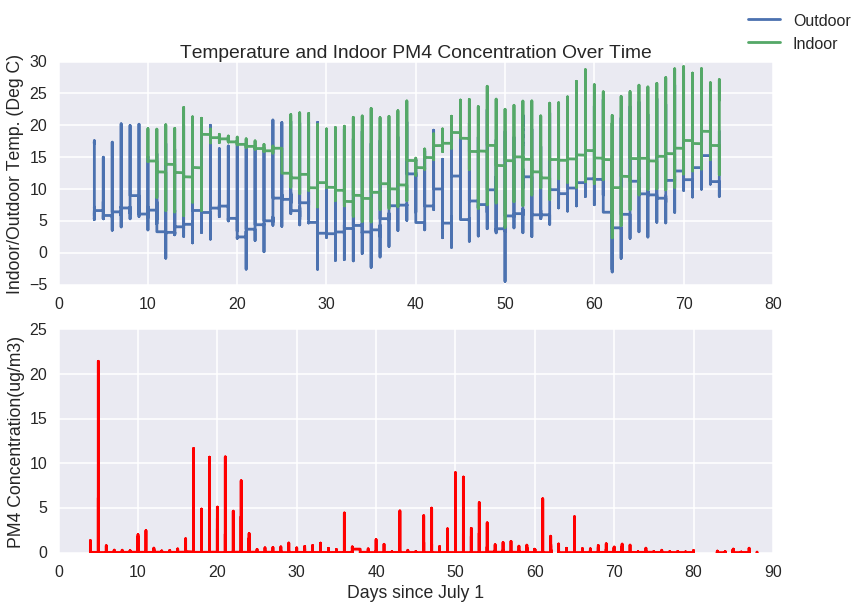

In [36]:
plt.figure(1)
plt.subplot(211)
plt.title('Temperature and Indoor PM4 Concentration Over Time')
plt.plot(df2013['DayCount'], df2013['Temperature_(degC)'])
plt.plot(df2013['DayCount'], df2013['AvgHouse'])
plt.ylabel('Indoor/Outdoor Temp. (Deg C)')
plt.legend(['Outdoor', 'Indoor'],bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)

plt.subplot(212)
plt.plot(df2013['DayCount'], df2013['PM4_(ug/m3)'], '-r')
plt.xlabel('Days since July 1')
plt.ylabel('PM4 Concentration(ug/m3)')
plt.show()

This visualizations above are noisy and unclear.This is because many of the trends we're looking at are periodic with a period of 24 hours (or 1 day). By taking the average temperature/concentration of each day of the winter and plotting that, we can see the trends over the course of the winter and get rid of daily periodic fluctuations.

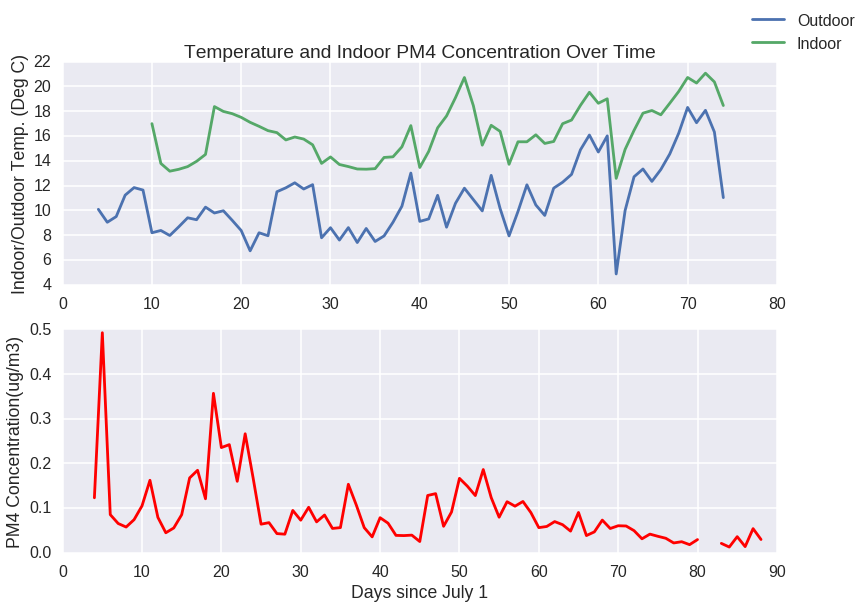

In [37]:
#By Daily Averages
plt.figure(1)

plt.subplot(211)
plt.title('Temperature and Indoor PM4 Concentration Over Time')
plt.plot(df2013['DayCount'], df2013['DailyAverageTemp'])
plt.plot(df2013['DayCount'], df2013['DailyAverageTempHouse'])
plt.ylabel('Indoor/Outdoor Temp. (Deg C)')
plt.legend(['Outdoor','Indoor'],bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)

plt.subplot(212)
plt.plot(df2013['DayCount'], df2013['DailyAvgPM4'], '-r')
plt.xlabel('Days since July 1')
plt.ylabel('PM4 Concentration(ug/m3)')
plt.show()

### Diurnal Profiles of the Data
Because the pollution is coming from coal burning within homes, which is influenced by daily routines, we see more meaningful trends when we examine this data on a daily basis (what an average day looks like). Diurnal profiles examine the periodic trends we smoothed out in our previous graphs, and recover more meaningful data that was lost in smoothing. The following graphs examine trends in average temperatures and pollutant concentrations.

In [9]:
#0-23 Hours of the day to use as x-axis for diurnal visualizations.
hourlist = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

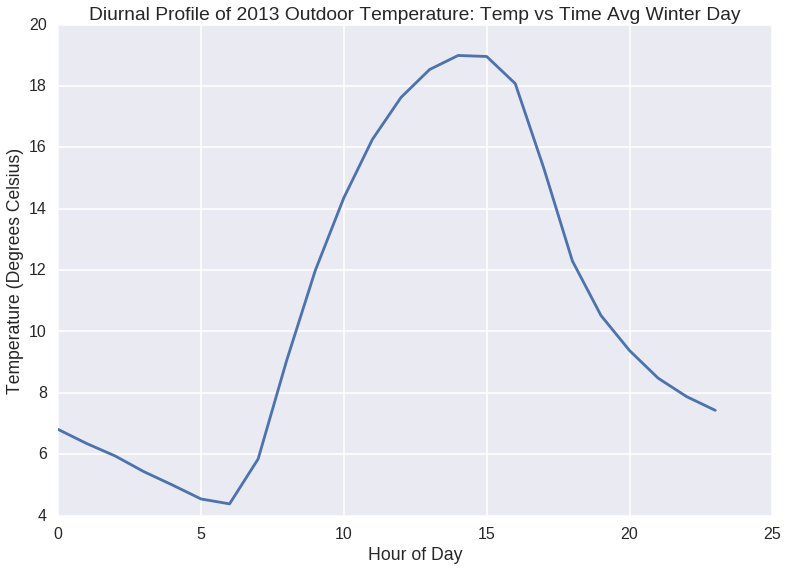

In [10]:
plt.plot(hourlist, featurediurnaldata(df2013, 'Temperature_(degC)'))
plt.title('Diurnal Profile of 2013 Outdoor Temperature: Temp vs Time Avg Winter Day')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature (Degrees Celsius)')
plt.show()

Below is average indoor temperature across all houses's kitchen sensors.(This recoding is done in the compute_avg_house functions)

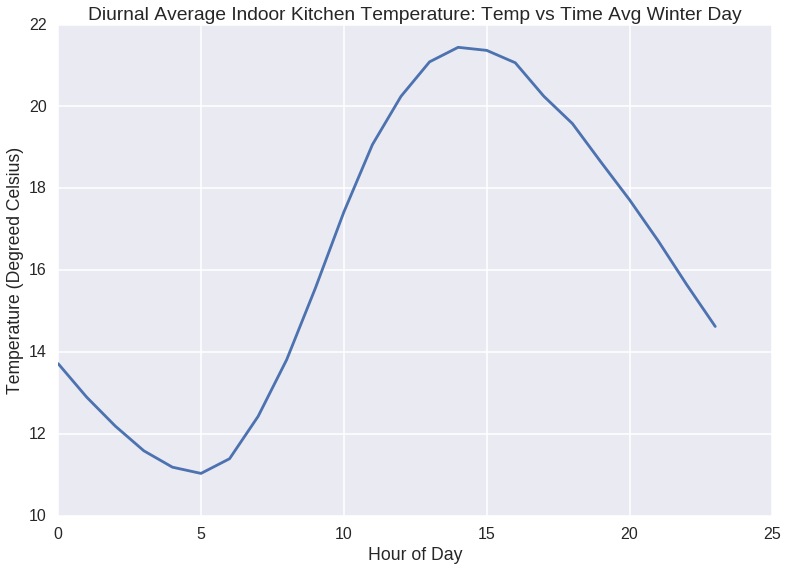

In [12]:
plt.plot(hourlist, featurediurnaldata(df2013, 'AvgHouse'))
plt.title('Diurnal Average Indoor Kitchen Temperature: Temp vs Time Avg Winter Day')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature (Degreed Celsius)')
plt.show()

We now look at the derivative of the difference between indoor and outdoor temperature over the course of a day. This helps track when burning actually happened and removes the temperature outside as a source of heat for the interior of the house

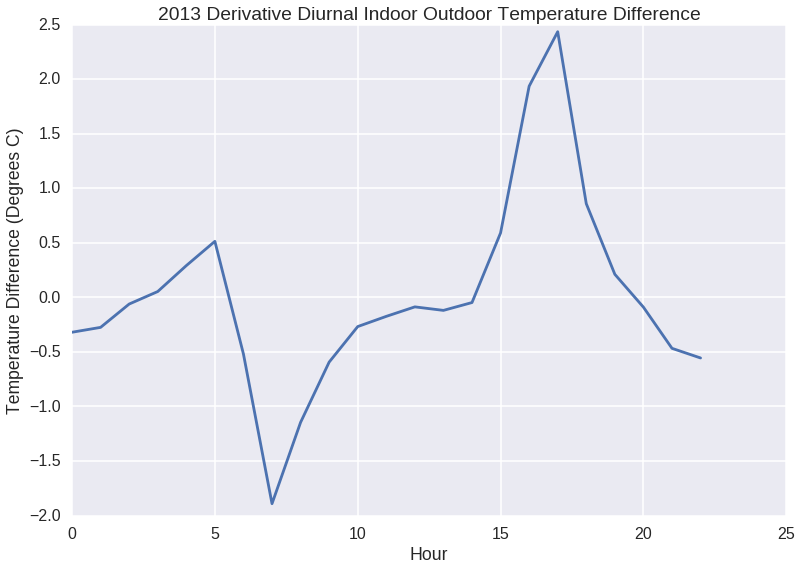

In [56]:
hourlist23 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
plt.plot(hourlist23, np.diff(featurediurnaldata(df2013, 'tempdifference')))
plt.title('2013 Derivative Diurnal Indoor Outdoor Temperature Difference')
plt.ylabel('Temperature Difference (Degrees C)')
plt.xlabel('Hour')
plt.show()

Here's the temperature difference, for reference to the derivative graph. This tells us less valuable information than the above derivative graph, but it's good to understand what the slopes look like and how we came to create the derivative

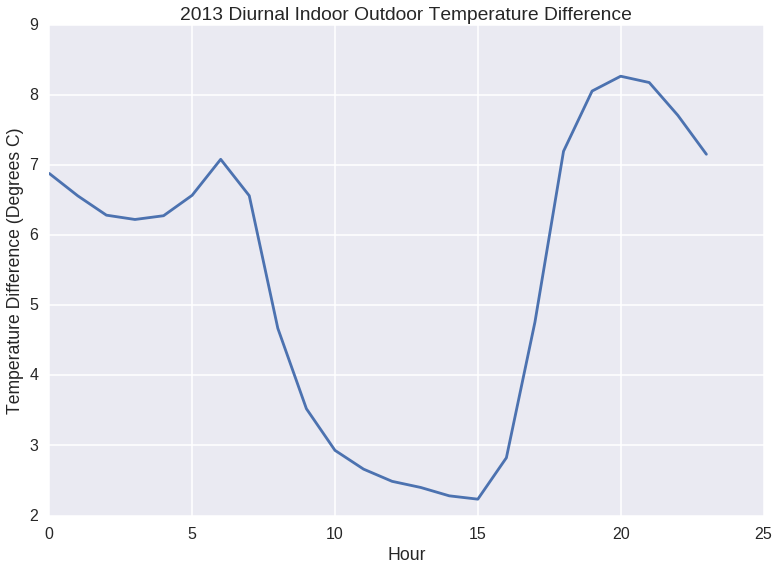

In [20]:
plt.plot(hourlist, featurediurnaldata(df2013, 'tempdifference'))
plt.title('2013 Diurnal Indoor Outdoor Temperature Difference')
plt.ylabel('Temperature Difference (Degrees C)')
plt.xlabel('Hour')
plt.show()

The PM4 concentration is the concentration of all pollutant particulate matter of 4 microns or less that is found indoors. These particles are particularly harmful to human health because they are small enough to flow into the respiratory tract and causes lung problems. They're also measurements taken exclusively indoors, and are caused only by indoor pollution sources, AKA burning coal. 

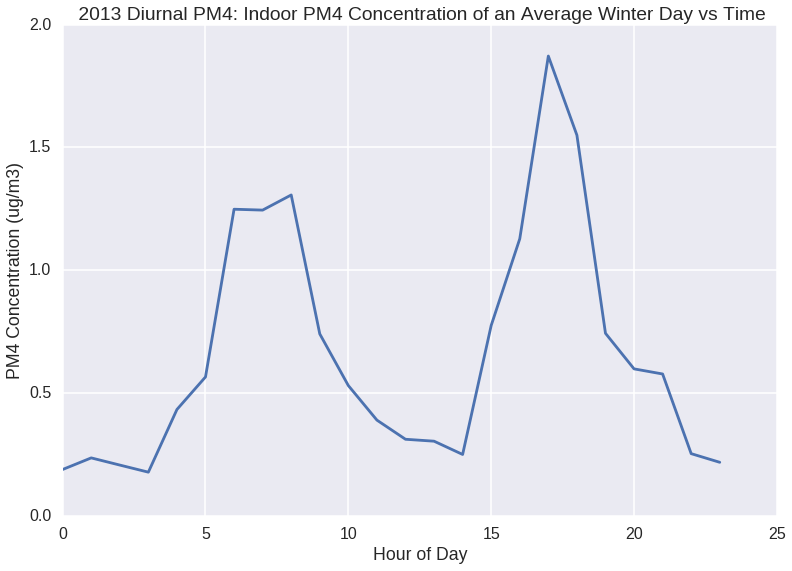

In [21]:
plt.plot(hourlist, featurediurnaldata(df2013, 'PM4_(ug/m3)'))
plt.title(' 2013 Diurnal PM4: Indoor PM4 Concentration of an Average Winter Day vs Time')
plt.xlabel('Hour of Day')
plt.ylabel('PM4 Concentration (ug/m3)')
plt.show()

PM10 concentration is the concentration of all pollutant particles less than 10 microns in diameter but greater than 2.5 microns; this measurement was also taken exclusively outside. This pollution can be caused by coal burning and also can be carried in by wind and other large weather patterns. It is also damaging to human health

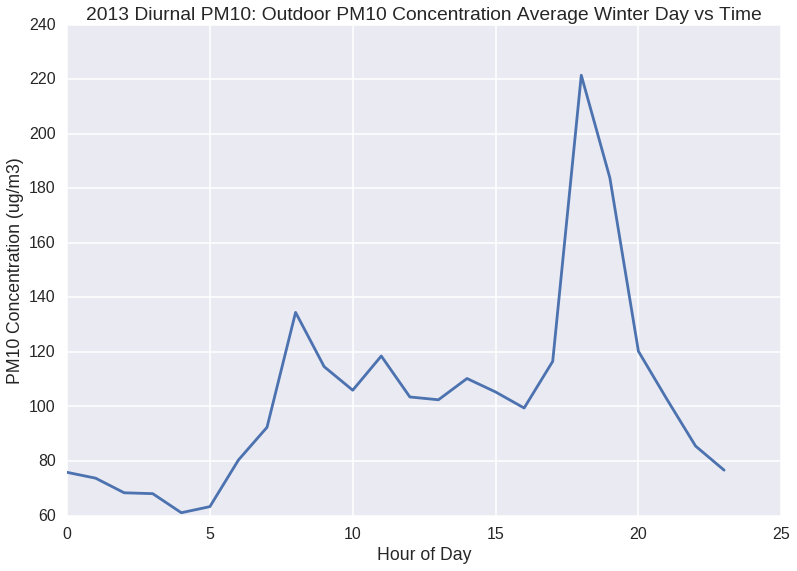

In [22]:
plt.plot(hourlist, featurediurnaldata(df2013, 'PM10_(ug/m3)'))
plt.title('2013 Diurnal PM10: Outdoor PM10 Concentration Average Winter Day vs Time')
plt.xlabel('Hour of Day')
plt.ylabel('PM10 Concentration (ug/m3)')
plt.show()

In a similar naming convention to other PM's PM2.5 is pollutant particles less than 2.5 microns in diameter. It is the smallest in size of the particulate pollutants and is therefore the most threatening to human health, as it deposits most easily in the lungs. PM2.5 was also measured exclusively outdoors

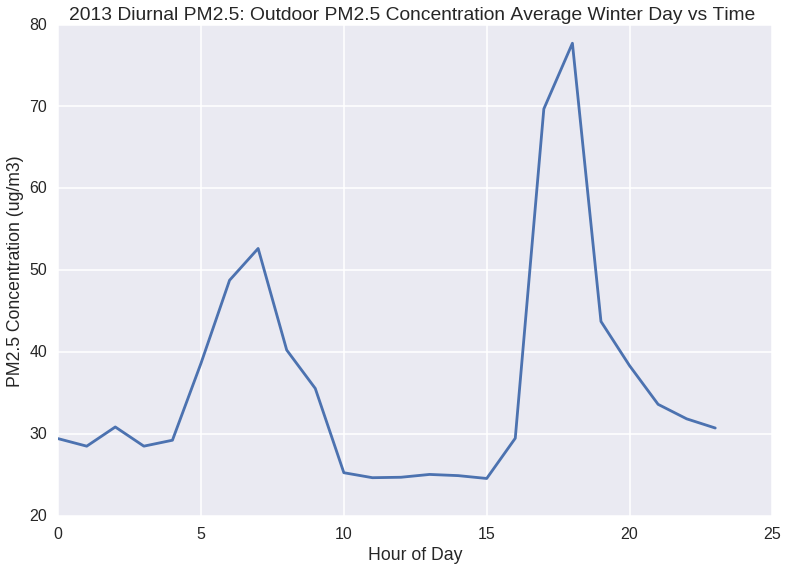

In [24]:
plt.plot(hourlist, featurediurnaldata(df2013, 'PM2.5_(ug/m3)'))
plt.title('2013 Diurnal PM2.5: Outdoor PM2.5 Concentration Average Winter Day vs Time ')
plt.xlabel('Hour of Day')
plt.ylabel('PM2.5 Concentration (ug/m3)')
plt.show()

CO, or corbon monoxide, is known as a "tracer pollutant" because it is a direct result of coal burning. CO is damaging to human health and is known in literature to correlate highly to burning of coal. Unfortunately, the CO data for 2013 was subject to error upon collection and could not be used accurately. Below is a graph of the 2014 data which has the same shape the 2013 data would have had, given it was correctly collected.

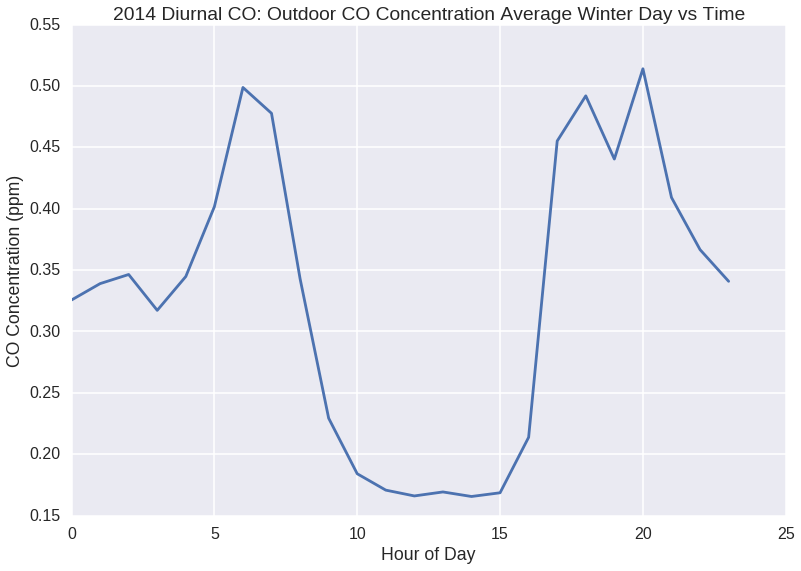

In [26]:
plt.plot(hourlist, featurediurnaldata(df2014, 'CO_(ppm)'))
plt.title('2014 Diurnal CO: Outdoor CO Concentration Average Winter Day vs Time')
plt.xlabel('Hour of Day')
plt.ylabel('CO Concentration (ppm)')
plt.show()

Every day has evident patterns. The later afternoon is the warmest portion of the day outdoors, and as the evening turns to night the interior of the house is warmed by the coal stove used to make a cooking fire. Pollutants spike in the morning and evening, indicating use of the stove for a combination of warmth and cooking. We know morning stove use is usually exclusively for heating the home after a cold night (people often wake just after midnight to stoke the fire) and for heathing water. In the evenings, residents of KwaDela use their stoves to cook dinner and keep the family warm for the night. The stove is used most heavily for dinnertime. 

## Compare 2013 & 2014 Data
### Pre Vs Post Intervention

For the winter of 2014, several interventions were put into place to retain heat in several homes and to reduce coal burning. The following section explores what effect the intervention had, and how data from the two winters compare. 

#### Over Entire Winter
The below set of graphs compares indoor and outdoor temperatures, as well as the PM4 concentrations. You can see 2014 was generally a little bit warmer than 2013, and it was significantly warmer indoors, indicating the intervention may have succeeded in making the homes warmer.
The PM4 data for 2014 looks a little bit off, so we took a look at some diurnal profiles to investigate furthur.

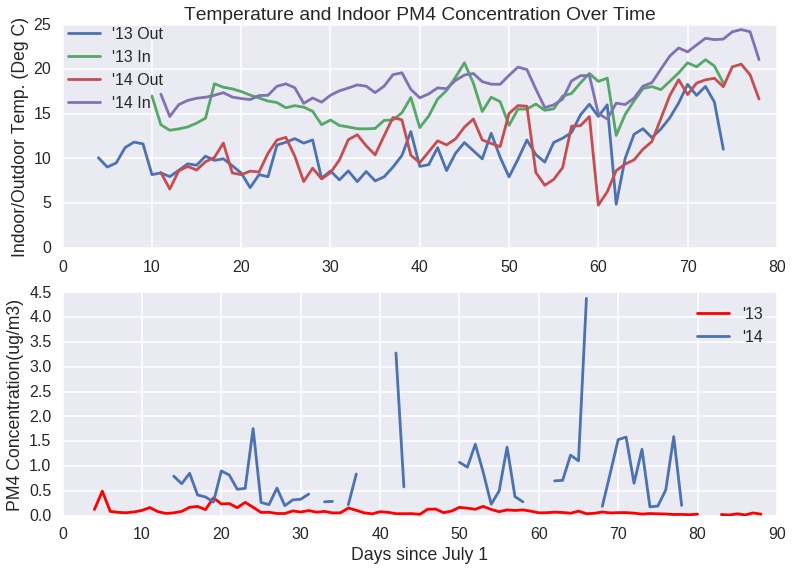

In [53]:
plt.figure(1)

plt.subplot(211)
plt.title('Temperature and Indoor PM4 Concentration Over Time')
plt.plot(df2013['DayCount'], df2013['DailyAverageTemp'])
plt.plot(df2013['DayCount'], df2013['DailyAverageTempHouse'])
plt.plot(df2014['DayCount'], df2014['DailyAverageTemp'])
plt.plot(df2014['DayCount'], df2014['DailyAverageTempHouse'])
plt.legend(['\'13 Out','\'13 In', '\'14 Out', '\'14 In'],bbox_to_anchor=(0.25, 0.92),
           bbox_transform=plt.gcf().transFigure)

plt.ylabel('Indoor/Outdoor Temp. (Deg C)')

plt.subplot(212)
plt.plot(df2013['DayCount'], df2013['DailyAvgPM4'], '-r')
plt.plot(df2014['DayCount'], df2014['DailyAvgPM4'])
plt.legend(['\'13', '\'14'])
plt.xlabel('Days since July 1')
plt.ylabel('PM4 Concentration(ug/m3)')

#### Diurnal Profiles
Each day in 2014 followed the same temperature trends as in 2013, but 2014 was generally warmer. This is shown in each graph that deals with temperature comparisons 

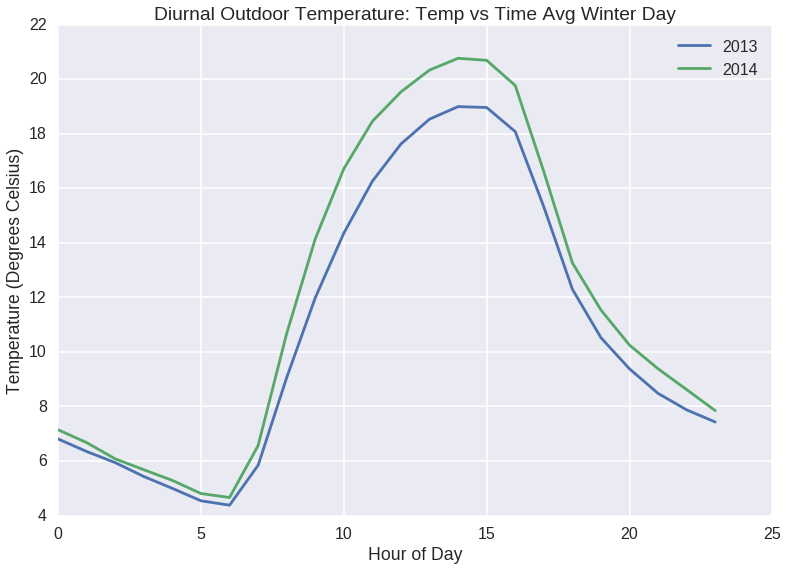

In [93]:
plt.plot(hourlist, featurediurnaldata(df2013, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014, 'Temperature_(degC)'))
plt.legend(['2013', '2014'])
plt.title('Diurnal Outdoor Temperature: Temp vs Time Avg Winter Day')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature (Degrees Celsius)')
plt.show()

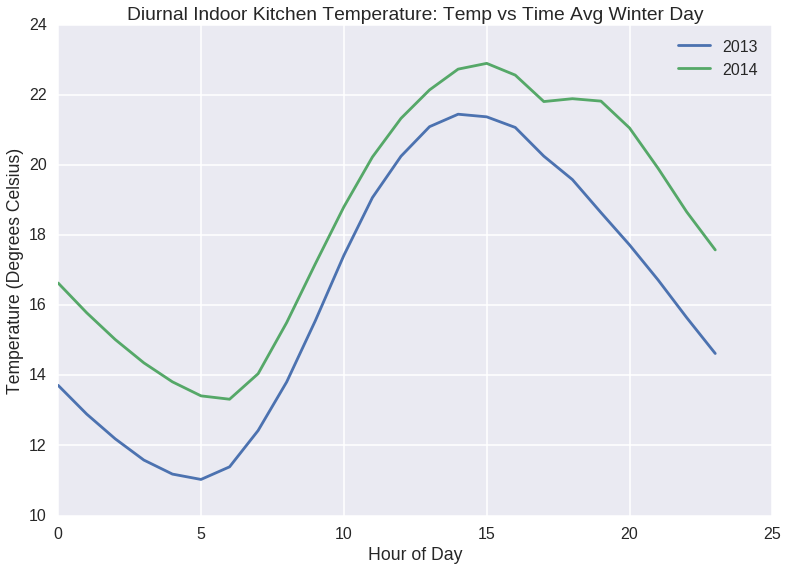

In [57]:
plt.plot(hourlist, featurediurnaldata(df2013, 'AvgHouse'))
plt.plot(hourlist, featurediurnaldata(df2014, 'AvgHouse'))

plt.legend(['2013', '2014'])
plt.title('Diurnal Indoor Kitchen Temperature: Temp vs Time Avg Winter Day')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature (Degrees Celsius)')
plt.show()


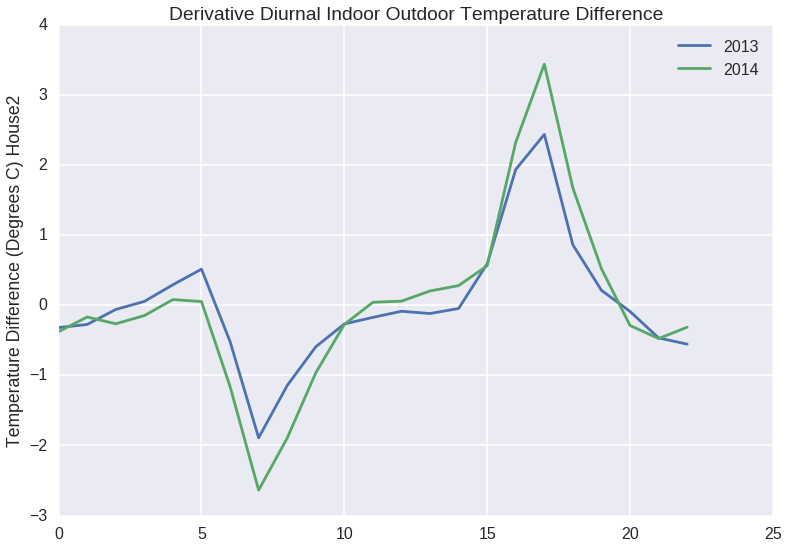

In [59]:
plt.plot(hourlist23, np.diff(featurediurnaldata(df2013, 'tempdifference')))
plt.plot(hourlist23, np.diff(featurediurnaldata(df2014, 'tempdifference')))
plt.title('Derivative Diurnal Indoor Outdoor Temperature Difference')
plt.legend(['2013', '2014'])
plt.ylabel('Temperature Difference (Degrees C) House2')
plt.show()

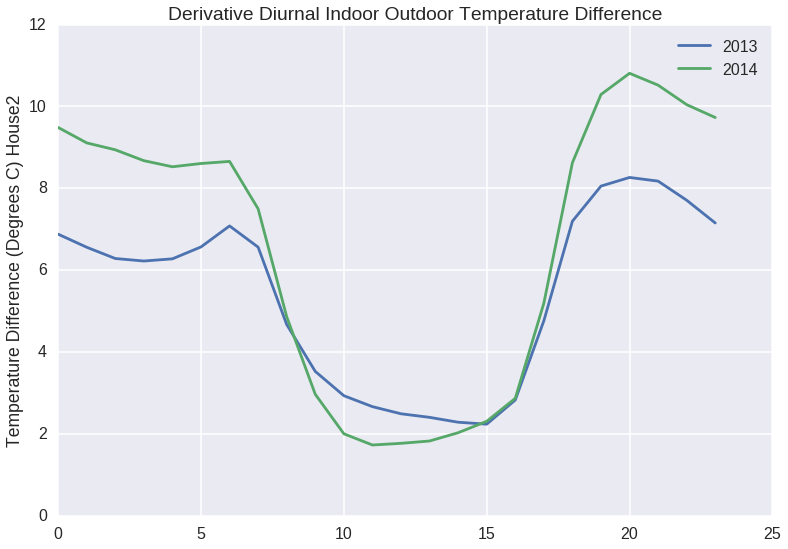

In [61]:
plt.plot(hourlist, featurediurnaldata(df2013, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2014, 'tempdifference'))
plt.title('Derivative Diurnal Indoor Outdoor Temperature Difference')
plt.legend(['2013', '2014'])
plt.ylabel('Temperature Difference (Degrees C) House2')
plt.show()

We did find an increase in PM4, which was worth more investigation later on. The outdoor pollutants saw a decrease, especially at times of peak stove use, indicating less coal burning happened in 2014. 

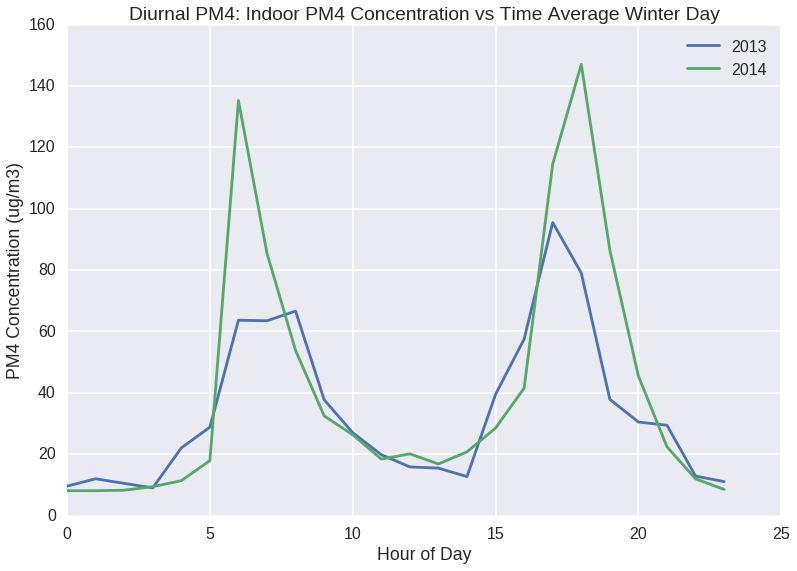

In [96]:
plt.plot(hourlist, featurediurnaldata(df2013, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014, 'PM4_(ug/m3)'))
plt.legend(['2013', '2014'])
plt.title('Diurnal PM4: Indoor PM4 Concentration vs Time Average Winter Day')
plt.xlabel('Hour of Day')
plt.ylabel('PM4 Concentration (ug/m3)')
plt.show()

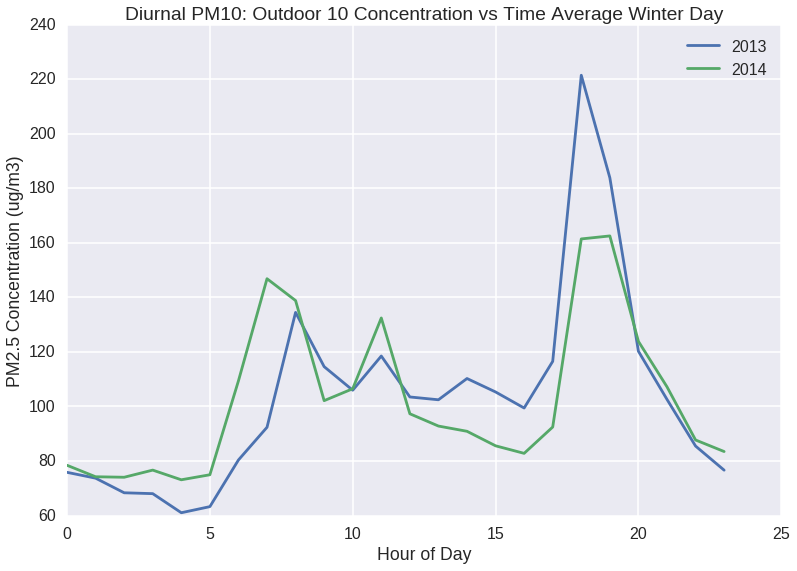

In [62]:
plt.plot(hourlist, featurediurnaldata(df2013, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014, 'PM10_(ug/m3)'))
plt.legend(['2013', '2014'])
plt.title('Diurnal PM10: Outdoor 10 Concentration vs Time Average Winter Day')
plt.xlabel('Hour of Day')
plt.ylabel('PM2.5 Concentration (ug/m3)')
plt.show()

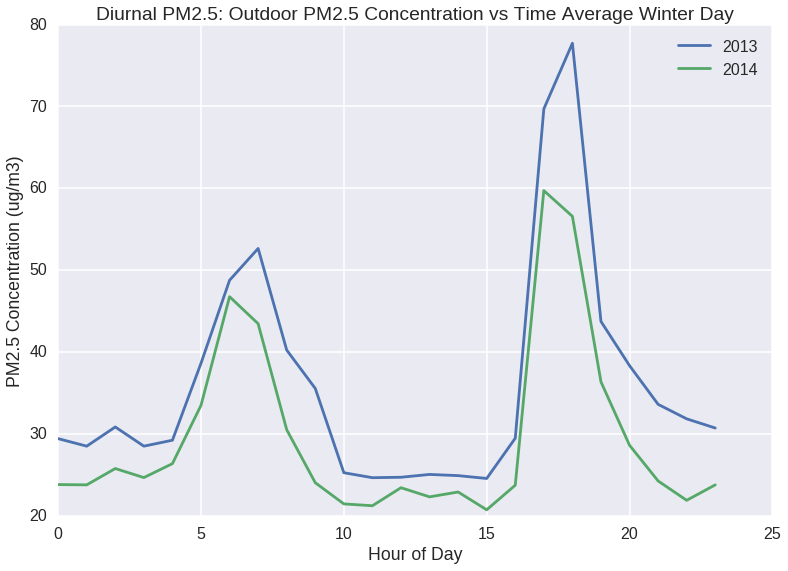

In [98]:
plt.plot(hourlist, featurediurnaldata(df2013, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014, 'PM2.5_(ug/m3)'))
plt.legend(['2013', '2014'])
plt.title('Diurnal PM2.5: Outdoor PM2.5 Concentration vs Time Average Winter Day')
plt.xlabel('Hour of Day')
plt.ylabel('PM2.5 Concentration (ug/m3)')
plt.show()

Unfortunately, lack of accurate CO readings left us unable to compare CO pollutants. This information would have been extremely valuable, and can hopefully be collected for future studies to compare.

### Separate days into temperature brackets: warm, medium, and cold days.

We created three temperature brackets to draw better comparisons between 2013 and 2014. Comparing an "average day" minimalizes the importance of cold days where large amounts of coal were burned. We wanted to set cutoff temperatures for these brackets so 2013 and 2014 could be comparable.

To find these cutoff temperatures, we found the IQR brackets of outdoor temperature for each year, and used the quartile cutoff temperatures of the warmer year, so that both will have at least 25% of their days counted as cold days.

2014 was the warmer year, so cold days are defined as days in either 2013 or 2014 where the average temperature of that day was colder than 25% of days in 2014.

In [63]:
df2013median = df2013['DailyAverageTemp'].median()
df2013abovemed = df2013[df2013['DailyAverageTemp'] > df2013median]
df2013belowmed = df2013[df2013['DailyAverageTemp'] < df2013median]
df2013Q3cutoff = df2013abovemed['DailyAverageTemp'].median()
df2013Q1cutoff = df2013belowmed['DailyAverageTemp'].median()

df2014median = df2014['DailyAverageTemp'].median()
df2014abovemed = df2014[df2014['DailyAverageTemp'] > df2014median]
df2014belowmed = df2014[df2014['DailyAverageTemp'] < df2014median]
df2014Q3cutoff = df2014abovemed['DailyAverageTemp'].median()
df2014Q1cutoff = df2014belowmed['DailyAverageTemp'].median()

print ('2013 cold temp cutoff = ')
print (df2013Q1cutoff)
print('2014 cold temp cutoff = ')
print(df2014Q1cutoff)
print('2014 warm temp cutoff')
print(df2014Q3cutoff)

2013 cold temp cutoff = 
8.6259
2014 cold temp cutoff = 
8.71066111111
2014 warm temp cutoff
14.4178590278


In [67]:
def bracketGenerator(df):
    """df: target year dataframe
    returns:three temperature bracket dataframes for cold, mid, and warm """
    warmcutoff = 14.4
    coldcutoff = 8.7

    dfcold = df[df['DailyAverageTemp'] <= coldcutoff]
    dfmid = df[df['DailyAverageTemp'] > coldcutoff]
    dfmid = dfmid[dfmid['DailyAverageTemp'] < warmcutoff]
    dfwarm = df[df['DailyAverageTemp'] >= warmcutoff]

    
    return dfcold,dfmid,dfwarm

We will from now on define warm days as days where the average outdoor temperature is above 14.4179 Degrees C, and cold days as days where the average outdoor temperature is below 8.7107 Degrees C.

In [68]:
df2013cold,df2013mid,df2013warm = bracketGenerator(df2013)
df2014cold,df2014mid,df2014warm = bracketGenerator(df2014)

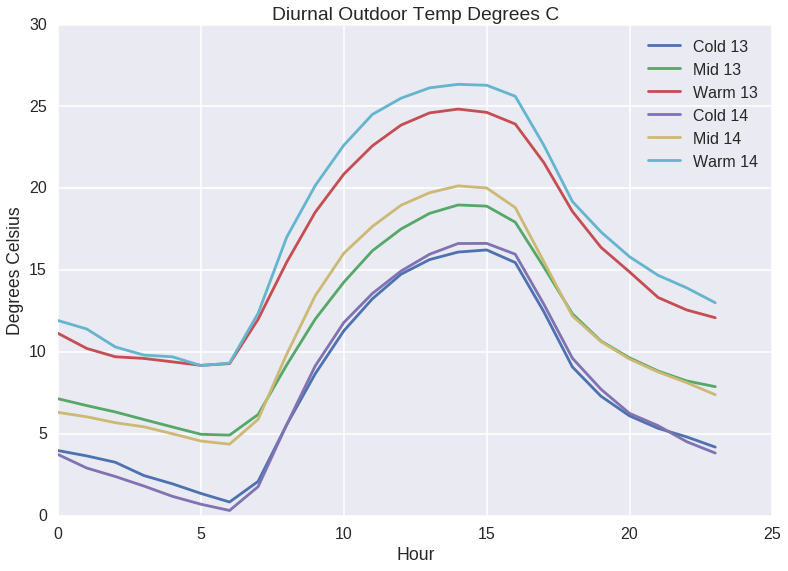

In [102]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'Temperature_(degC)'))         
      
plt.legend(['Cold 13', 'Mid 13', 'Warm 13', 'Cold 14', 'Mid 14', 'Warm 14'])
plt.title('Diurnal Outdoor Temp Degrees C')
plt.xlabel('Hour')
plt.ylabel('Degrees Celsius')
plt.show()

With these temperature  brackets, the 2013 and 2014 data, particularly for the cold days is comparable diurnally, and we can now compare cold and warm days to each other.

#### Outdoor Temperature

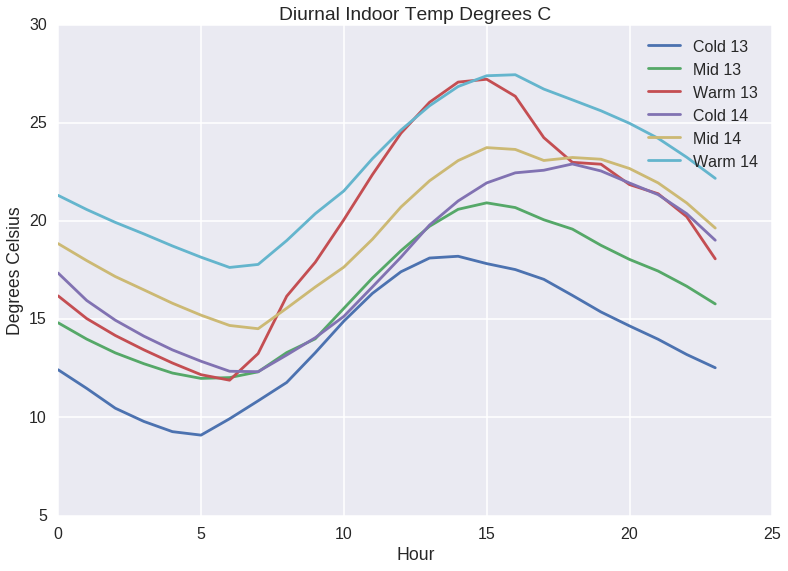

In [103]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'H02-K-N'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'H02-K-N'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'H02-K-N'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'H02-K-N'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'H02-K-N'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'H02-K-N'))         
      
plt.legend(['Cold 13', 'Mid 13', 'Warm 13', 'Cold 14', 'Mid 14', 'Warm 14'])
plt.title('Diurnal Indoor Temp Degrees C')
plt.xlabel('Hour')
plt.ylabel('Degrees Celsius')

plt.show()



#### Indoor Temperature

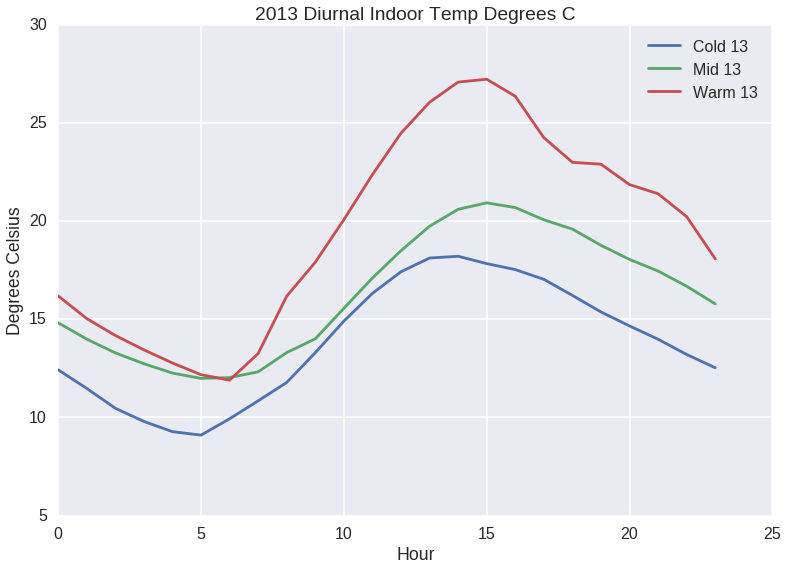

In [104]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'H02-K-N'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'H02-K-N'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'H02-K-N'))      
      
plt.legend(['Cold 13', 'Mid 13', 'Warm 13'])
plt.title('2013 Diurnal Indoor Temp Degrees C')
plt.xlabel('Hour')
plt.ylabel('Degrees Celsius')

plt.show()



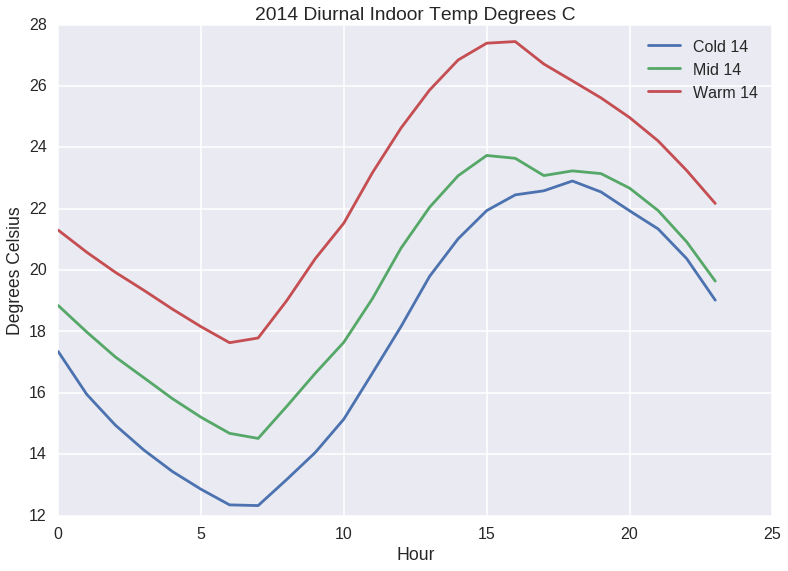

In [105]:
plt.plot(hourlist, featurediurnaldata(df2014cold, 'H02-K-N'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'H02-K-N'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'H02-K-N'))      
      
plt.legend(['Cold 14', 'Mid 14', 'Warm 14'])
plt.title('2014 Diurnal Indoor Temp Degrees C')
plt.xlabel('Hour')
plt.ylabel('Degrees Celsius')

plt.show()



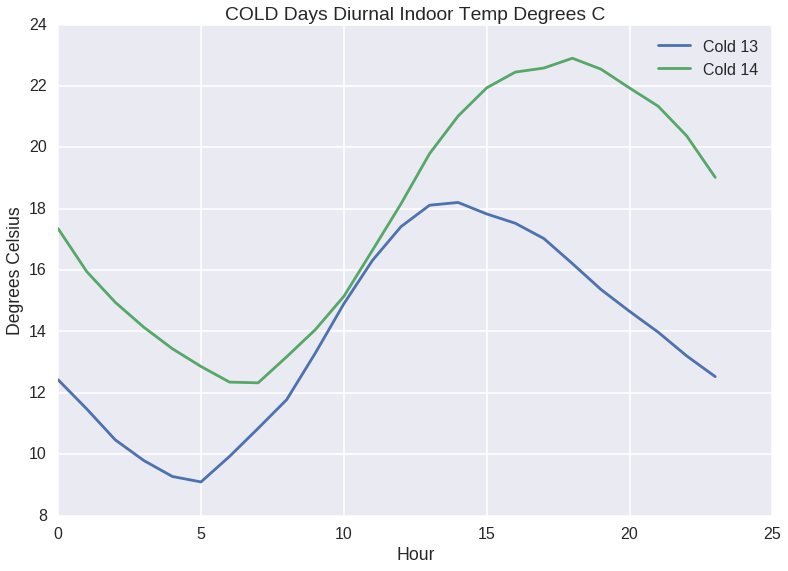

In [106]:
sns.set_context("poster")
plt.plot(hourlist, featurediurnaldata(df2013cold, 'H02-K-N'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'H02-K-N'))

plt.legend(['Cold 13', 'Cold 14'])
plt.title('COLD Days Diurnal Indoor Temp Degrees C')
plt.xlabel('Hour')
plt.ylabel('Degrees Celsius')

plt.show()



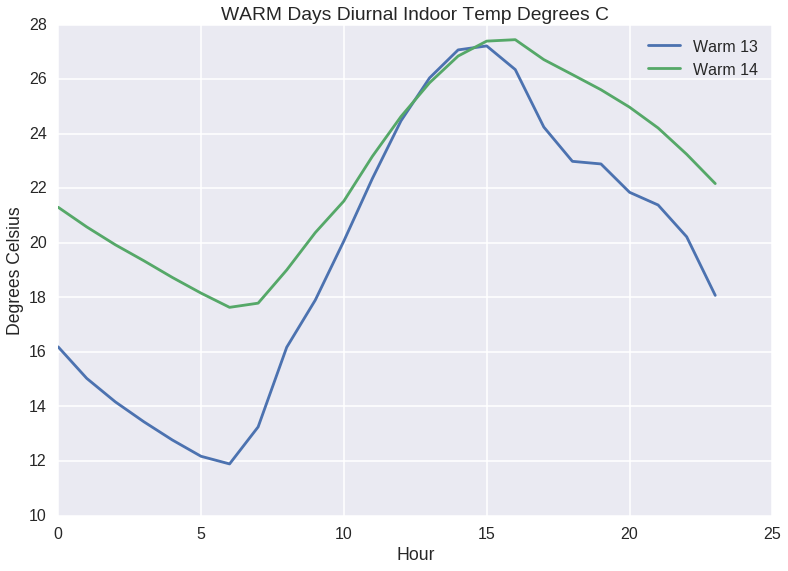

In [107]:


plt.plot(hourlist, featurediurnaldata(df2013warm, 'H02-K-N'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'H02-K-N'))

plt.legend(['Warm 13', 'Warm 14'])
plt.title('WARM Days Diurnal Indoor Temp Degrees C')
plt.xlabel('Hour')
plt.ylabel('Degrees Celsius')

plt.show()


#### Indoor/Outdoor Temperature Difference

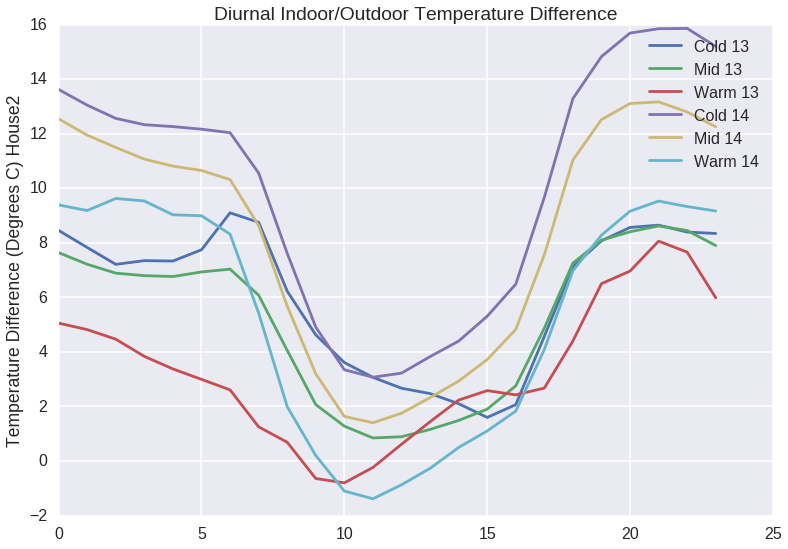

In [108]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'tempdifference'))
plt.title('Diurnal Indoor/Outdoor Temperature Difference')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13', 'Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('Temperature Difference (Degrees C) House2') 
plt.show()

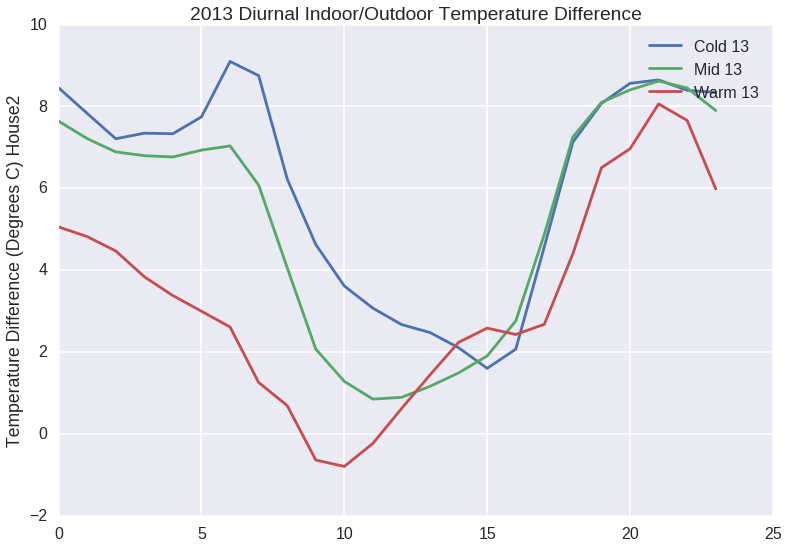

In [109]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'tempdifference'))
plt.title('2013 Diurnal Indoor/Outdoor Temperature Difference')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13'])
plt.ylabel('Temperature Difference (Degrees C) House2') 
plt.show()

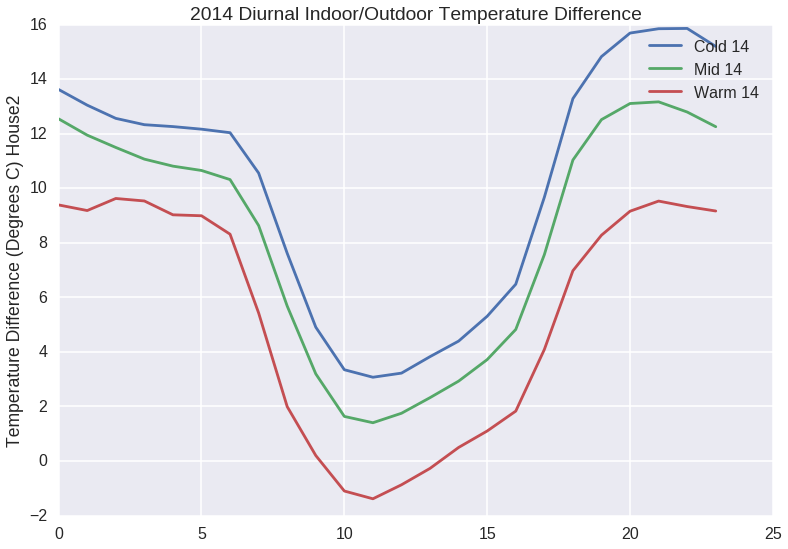

In [110]:
plt.plot(hourlist, featurediurnaldata(df2014cold, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'tempdifference'))
plt.title('2014 Diurnal Indoor/Outdoor Temperature Difference')
plt.legend(['Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('Temperature Difference (Degrees C) House2') 
plt.show()

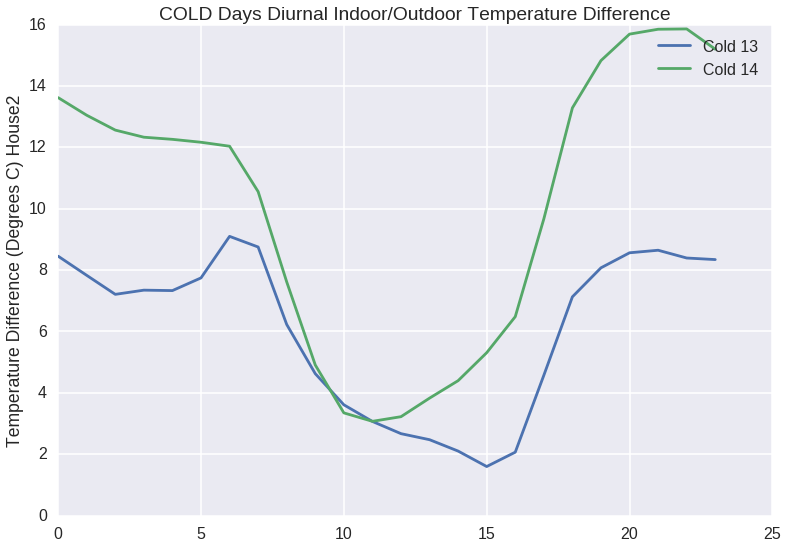

In [111]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'tempdifference'))
plt.title('COLD Days Diurnal Indoor/Outdoor Temperature Difference')
plt.legend(['Cold 13', 'Cold 14'])
plt.ylabel('Temperature Difference (Degrees C) House2') 
plt.show()

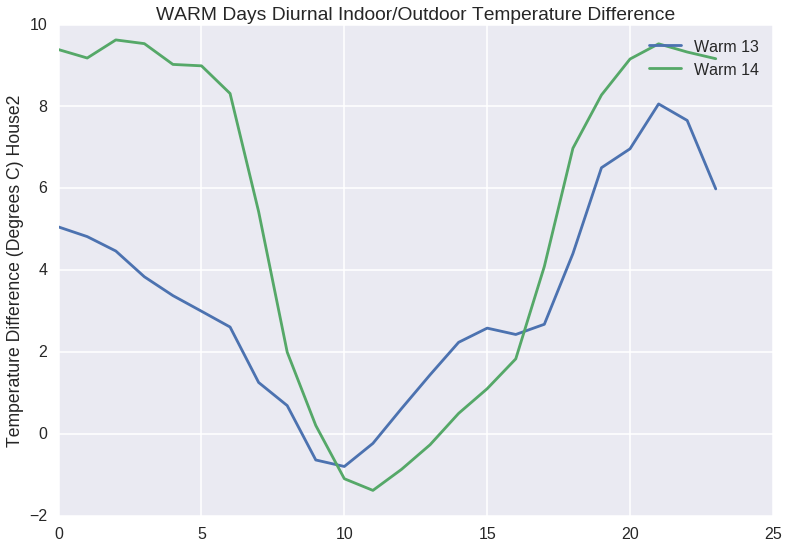

In [112]:
plt.plot(hourlist, featurediurnaldata(df2013warm, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'tempdifference'))
plt.title('WARM Days Diurnal Indoor/Outdoor Temperature Difference')
plt.legend(['Warm 13', 'Warm 14'])
plt.ylabel('Temperature Difference (Degrees C) House2') 
plt.show()

#### PM4

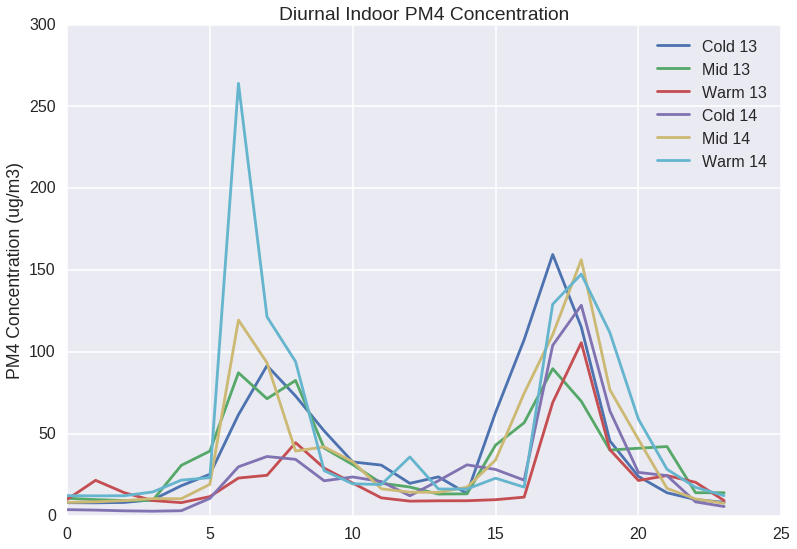

In [113]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'PM4_(ug/m3)'))
plt.title('Diurnal Indoor PM4 Concentration')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13', 'Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('PM4 Concentration (ug/m3)') 
plt.show()


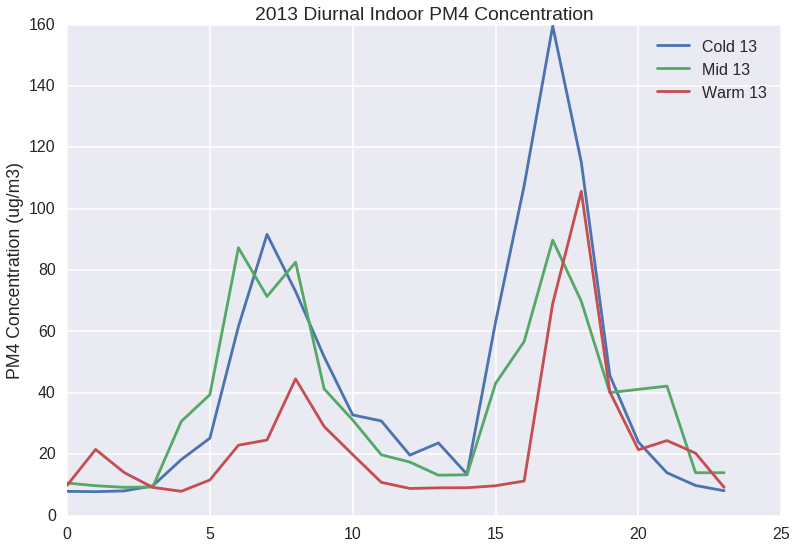

In [114]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'PM4_(ug/m3)'))
plt.title('2013 Diurnal Indoor PM4 Concentration')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13'])
plt.ylabel('PM4 Concentration (ug/m3)') 
plt.show()


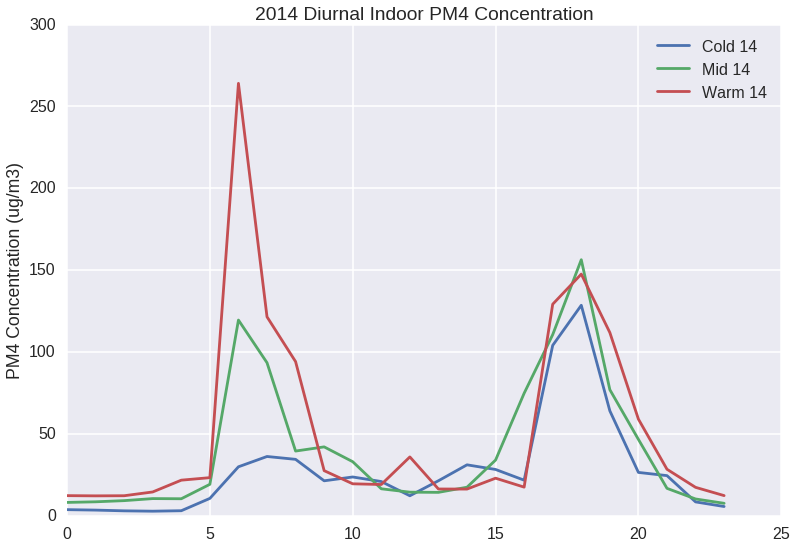

In [115]:
plt.plot(hourlist, featurediurnaldata(df2014cold, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'PM4_(ug/m3)'))
plt.title('2014 Diurnal Indoor PM4 Concentration')
plt.legend(['Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('PM4 Concentration (ug/m3)') 
plt.show()


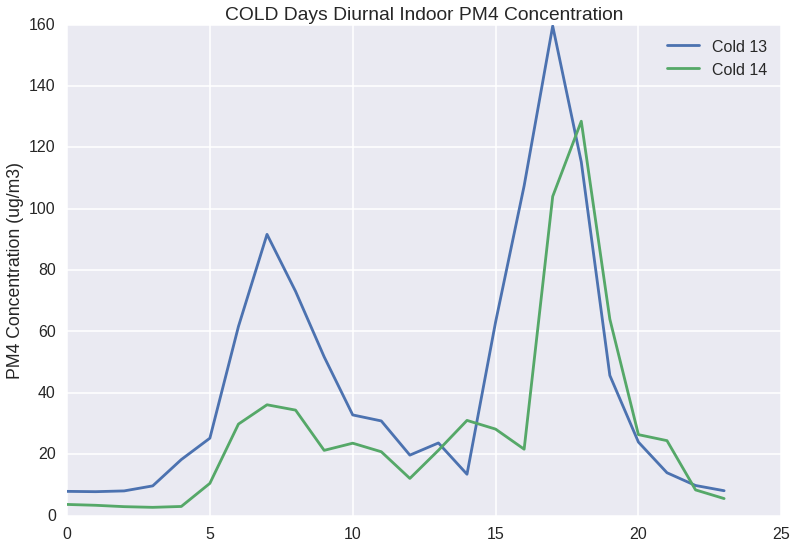

In [116]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'PM4_(ug/m3)'))
plt.title('COLD Days Diurnal Indoor PM4 Concentration')
plt.legend(['Cold 13','Cold 14'])
plt.ylabel('PM4 Concentration (ug/m3)') 
plt.show()


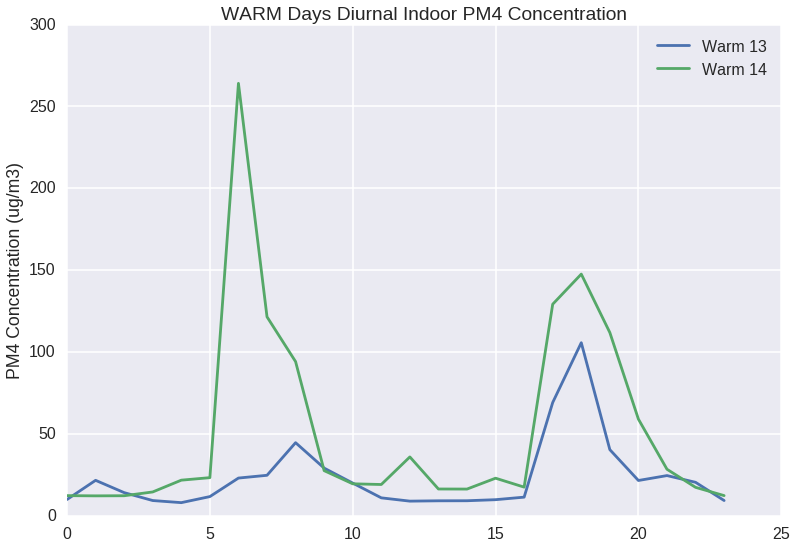

In [117]:
plt.plot(hourlist, featurediurnaldata(df2013warm, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'PM4_(ug/m3)'))
plt.title('WARM Days Diurnal Indoor PM4 Concentration')
plt.legend(['Warm 13', 'Warm 14'])
plt.ylabel('PM4 Concentration (ug/m3)') 
plt.show()


#### PM10

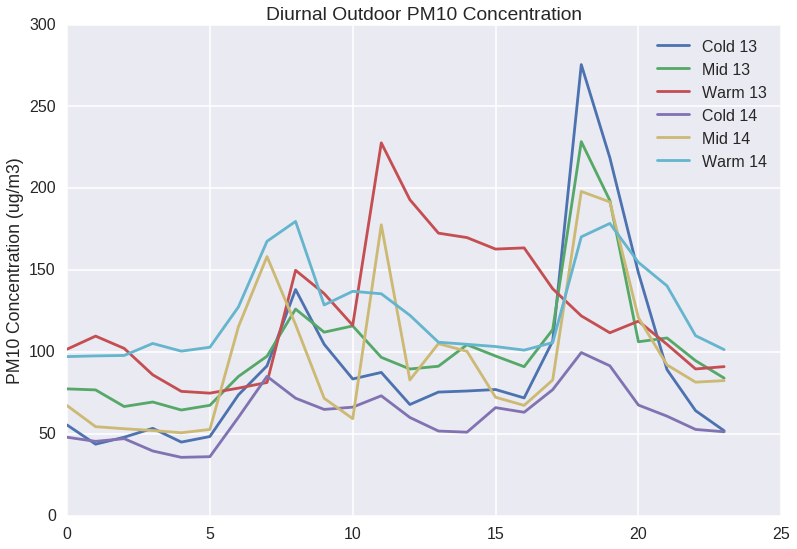

In [118]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'PM10_(ug/m3)'))
plt.title('Diurnal Outdoor PM10 Concentration')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13', 'Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('PM10 Concentration (ug/m3)') 
plt.show()


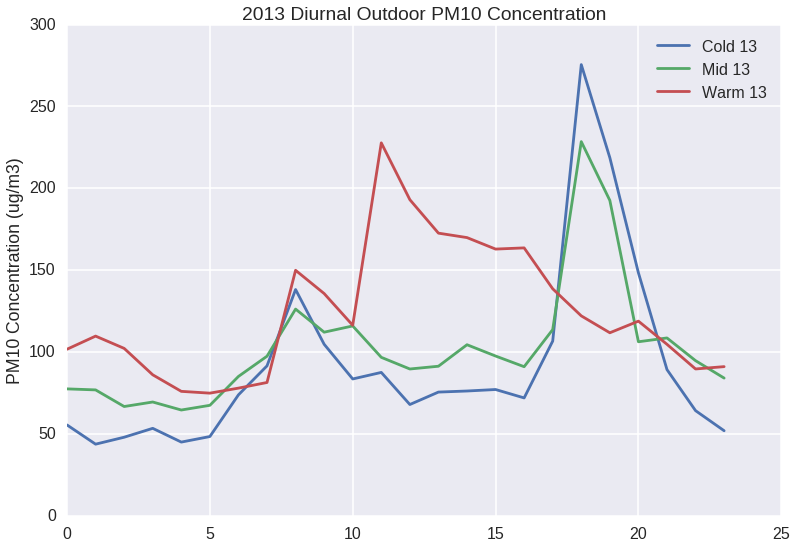

In [119]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'PM10_(ug/m3)'))
plt.title('2013 Diurnal Outdoor PM10 Concentration')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13'])
plt.ylabel('PM10 Concentration (ug/m3)') 
plt.show()


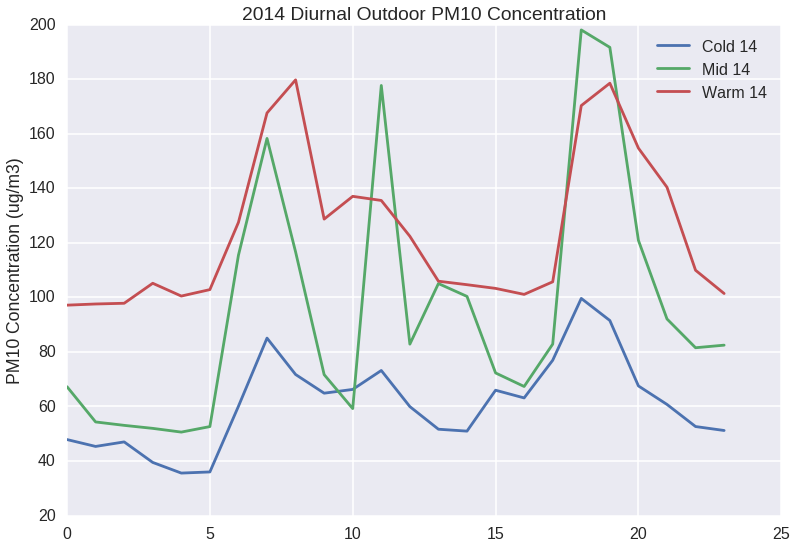

In [120]:
plt.plot(hourlist, featurediurnaldata(df2014cold, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'PM10_(ug/m3)'))
plt.title('2014 Diurnal Outdoor PM10 Concentration')
plt.legend(['Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('PM10 Concentration (ug/m3)') 
plt.show()


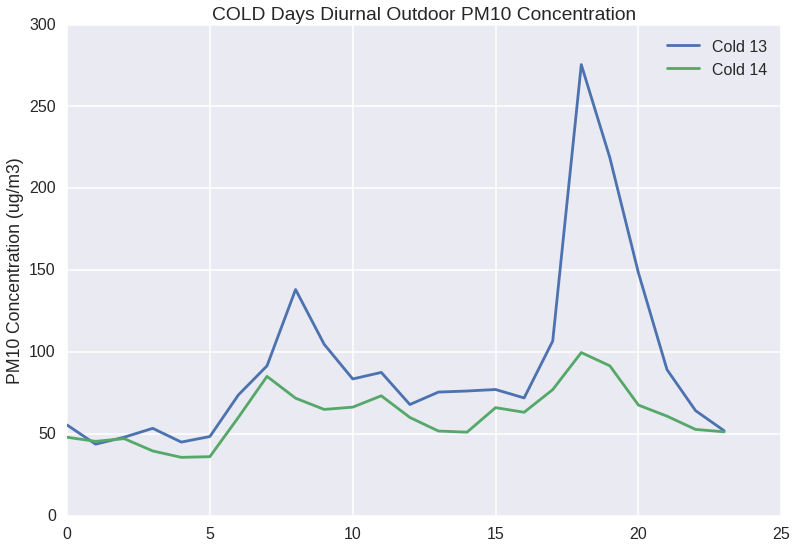

In [121]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'PM10_(ug/m3)'))
plt.title('COLD Days Diurnal Outdoor PM10 Concentration')
plt.legend(['Cold 13', 'Cold 14'])
plt.ylabel('PM10 Concentration (ug/m3)') 
plt.show()


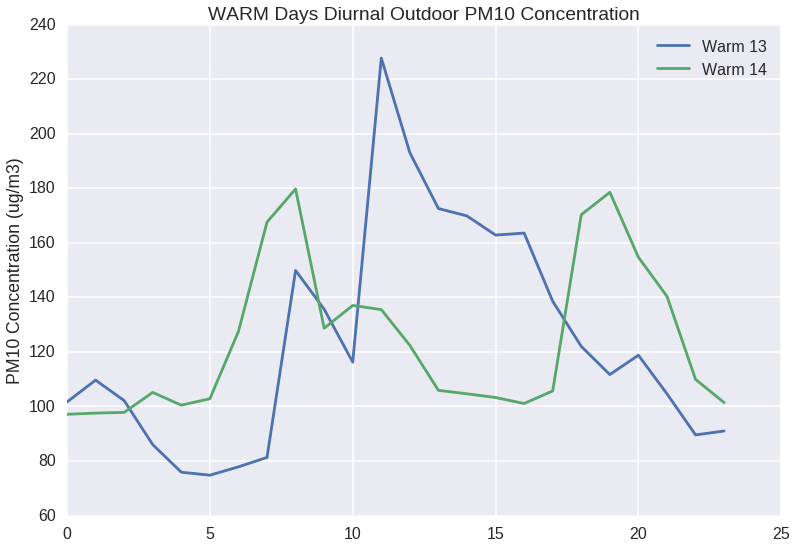

In [122]:
plt.plot(hourlist, featurediurnaldata(df2013warm, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'PM10_(ug/m3)'))
plt.title('WARM Days Diurnal Outdoor PM10 Concentration')
plt.legend(['Warm 13','Warm 14'])
plt.ylabel('PM10 Concentration (ug/m3)') 
plt.show()


#### PM2.5

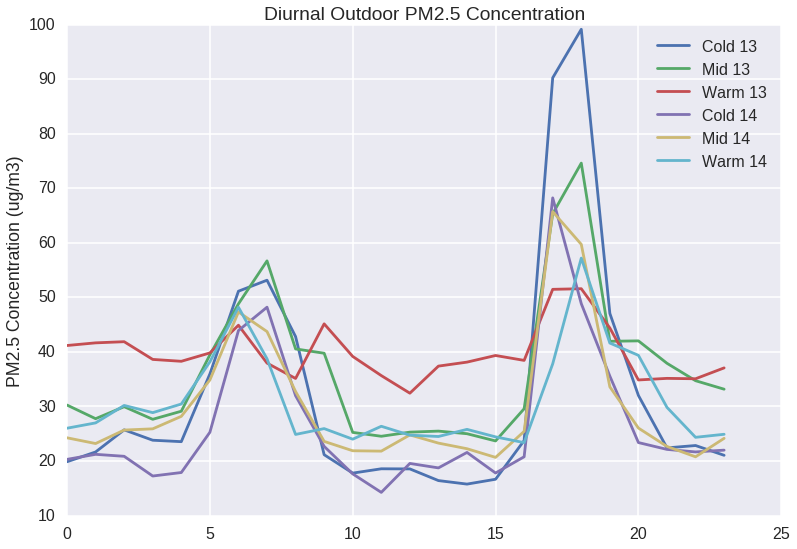

In [123]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'PM2.5_(ug/m3)'))
plt.title('Diurnal Outdoor PM2.5 Concentration')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13', 'Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('PM2.5 Concentration (ug/m3)') 
plt.show()

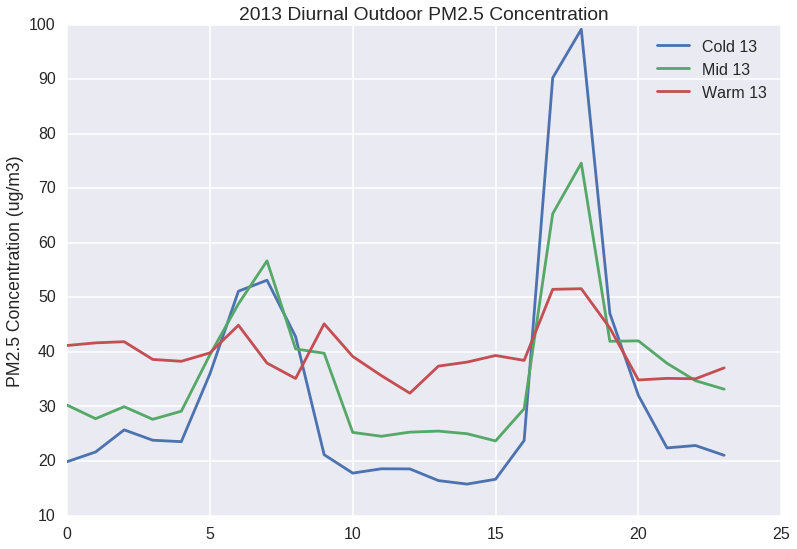

In [124]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'PM2.5_(ug/m3)'))
plt.title('2013 Diurnal Outdoor PM2.5 Concentration')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13'])
plt.ylabel('PM2.5 Concentration (ug/m3)') 
plt.show()

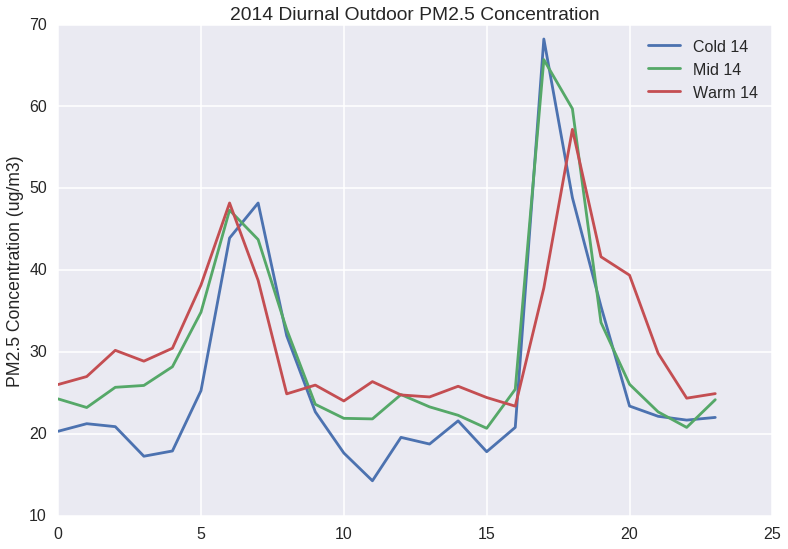

In [125]:
plt.plot(hourlist, featurediurnaldata(df2014cold, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'PM2.5_(ug/m3)'))
plt.title('2014 Diurnal Outdoor PM2.5 Concentration')
plt.legend(['Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('PM2.5 Concentration (ug/m3)') 
plt.show()

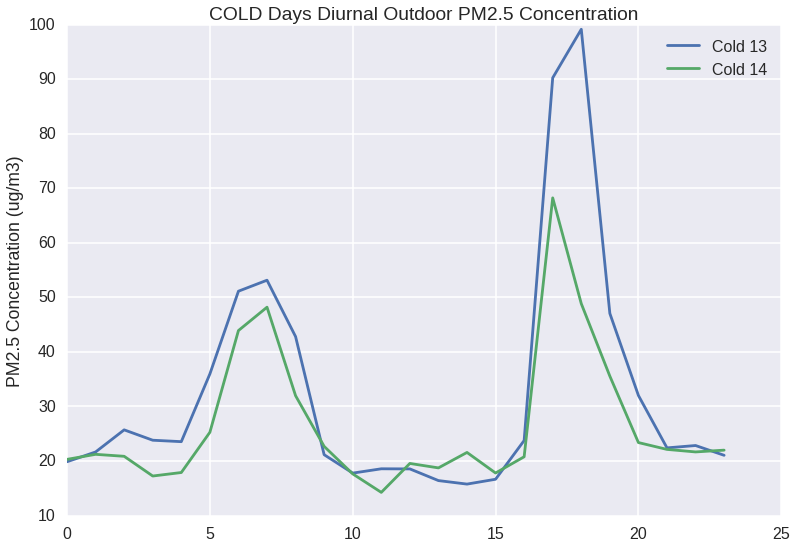

In [126]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'PM2.5_(ug/m3)'))
plt.title('COLD Days Diurnal Outdoor PM2.5 Concentration')
plt.legend(['Cold 13', 'Cold 14'])
plt.ylabel('PM2.5 Concentration (ug/m3)') 
plt.show()

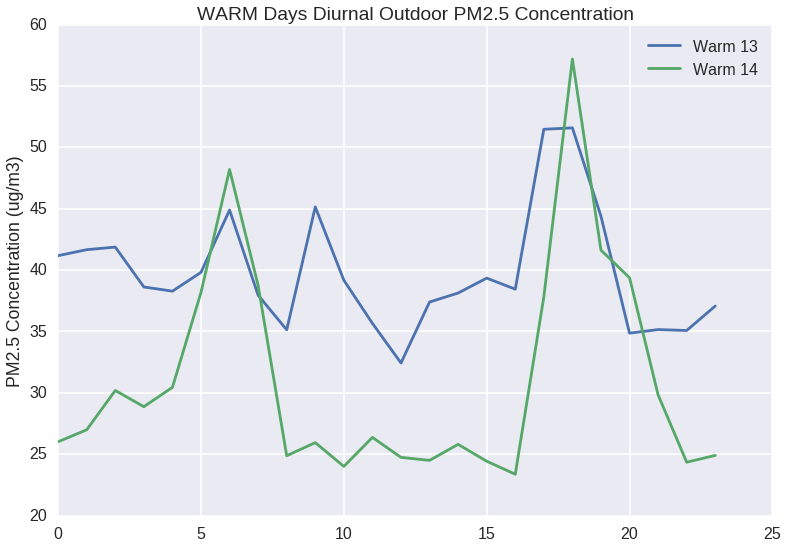

In [127]:
plt.plot(hourlist, featurediurnaldata(df2013warm, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'PM2.5_(ug/m3)'))
plt.title('WARM Days Diurnal Outdoor PM2.5 Concentration')
plt.legend(['Warm 13','Warm 14'])
plt.ylabel('PM2.5 Concentration (ug/m3)') 
plt.show()

#### CO

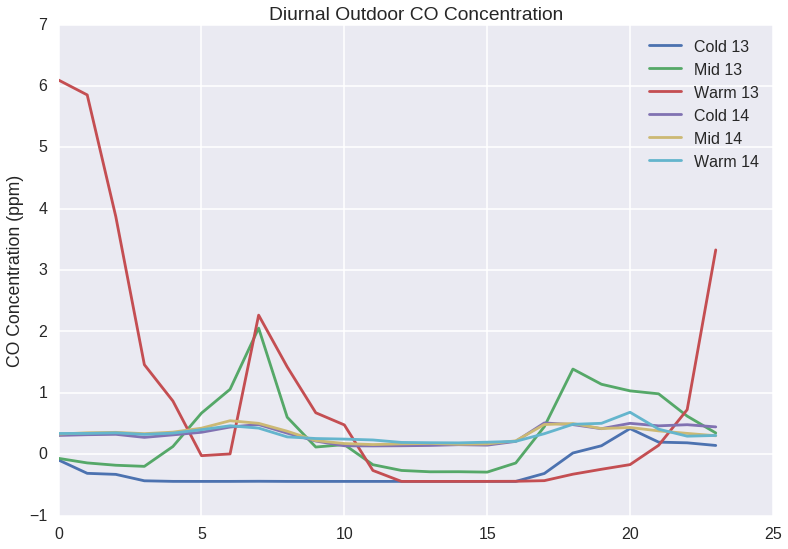

In [128]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'CO_(ppm)'))
plt.title('Diurnal Outdoor CO Concentration')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13', 'Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('CO Concentration (ppm)') 
plt.show()


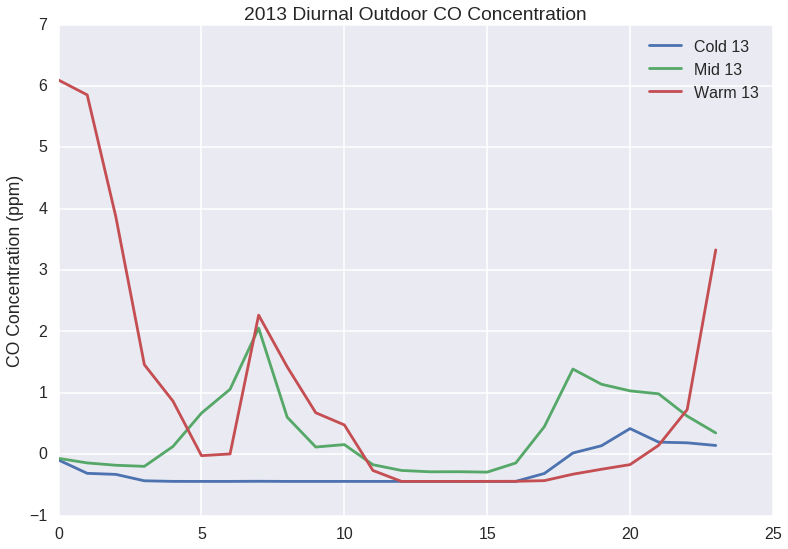

In [129]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'CO_(ppm)'))
plt.title('2013 Diurnal Outdoor CO Concentration')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13'])
plt.ylabel('CO Concentration (ppm)') 
plt.show()


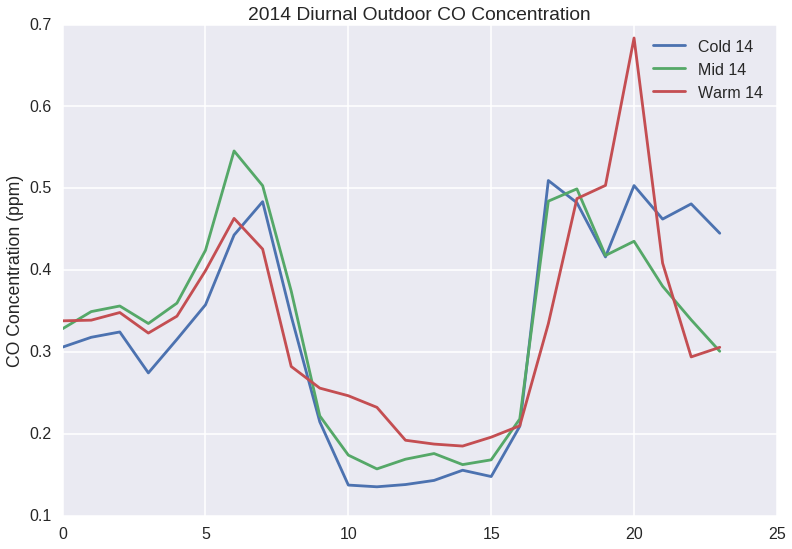

In [130]:
plt.plot(hourlist, featurediurnaldata(df2014cold, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'CO_(ppm)'))
plt.title('2014 Diurnal Outdoor CO Concentration')
plt.legend(['Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('CO Concentration (ppm)') 
plt.show()


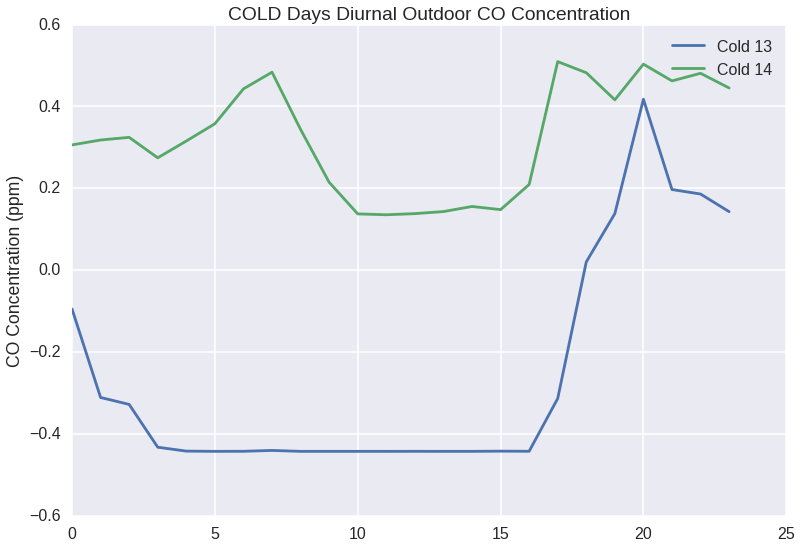

In [131]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'CO_(ppm)'))
plt.title('COLD Days Diurnal Outdoor CO Concentration')
plt.legend(['Cold 13', 'Cold 14'])
plt.ylabel('CO Concentration (ppm)') 
plt.show()


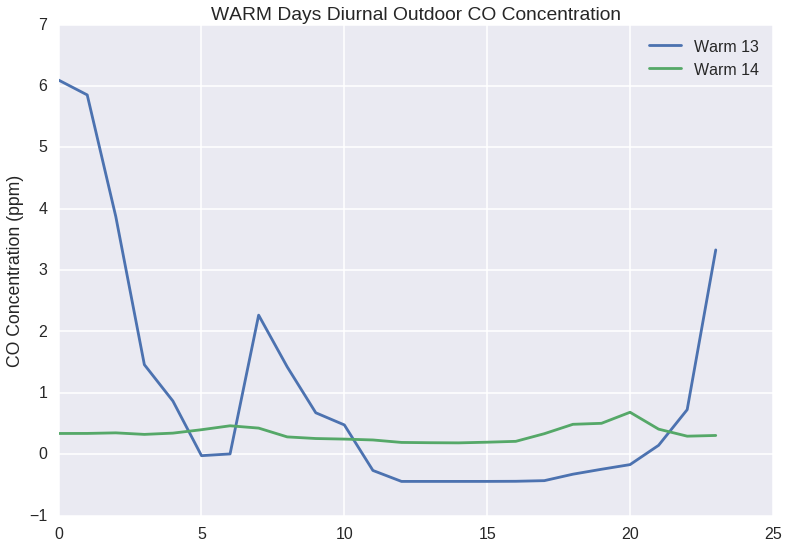

In [132]:
plt.plot(hourlist, featurediurnaldata(df2013warm, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'CO_(ppm)'))
plt.title('WARM Days Diurnal Outdoor CO Concentration')
plt.legend(['Warm 13','Warm 14'])
plt.ylabel('CO Concentration (ppm)') 
plt.show()


CO Data was inconclusive.

### We explored splitting the dataframes up by time of day.
#### The different peaks would give us different information - the evening peak was more becuase of dinner, while the morning peak was caused by making tea but mostly hetating.

#### The graphs below are helpful in visualizing what each time bracket is.  
A, C, and E are the baseline, either middle of the day or middle of the night, when people aren't burning.
B is the morning when people get up, make tea, and heat up their homes.
D is the evening when people make dinner.

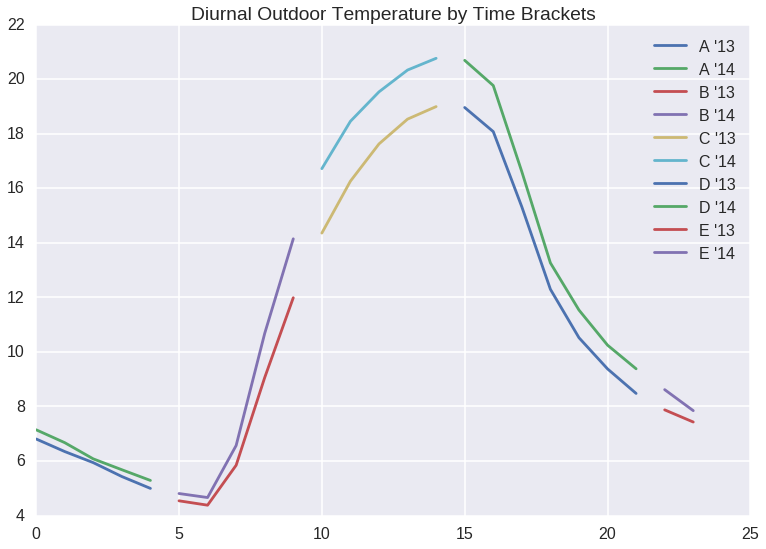

In [133]:
[df2013A, df2013B, df2013C, df2013D, df2013E] = abcdeTimeDataframes(df2013)
[df2014A, df2014B, df2014C, df2014D, df2014E] = abcdeTimeDataframes(df2014)


plt.plot(hourlist, featurediurnaldata(df2013A, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014A, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013B, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014B, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013C, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014C, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013D, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014D, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013E, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014E, 'Temperature_(degC)'))
plt.legend(["A '13", "A '14", "B '13", "B '14", "C '13", "C '14", "D '13", "D '14", "E '13", "E '14" ])
plt.title('Diurnal Outdoor Temperature by Time Brackets')
plt.show()

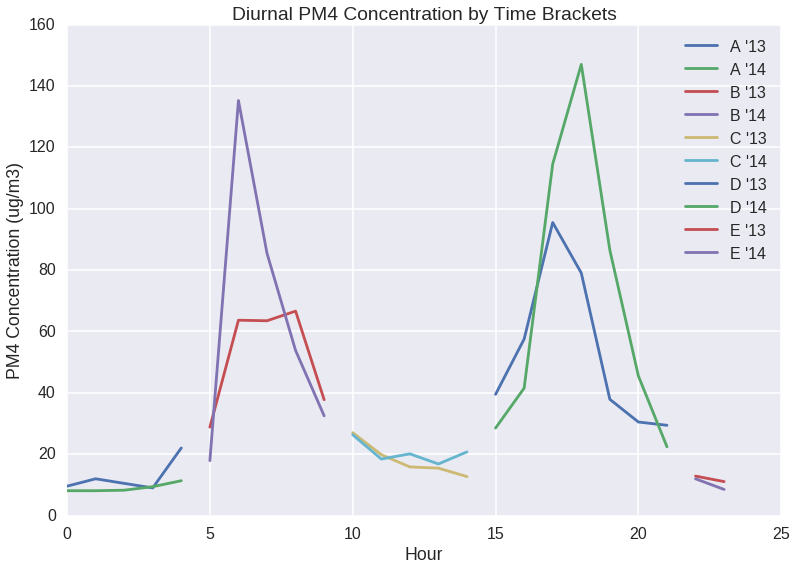

In [134]:
plt.plot(hourlist, featurediurnaldata(df2013A, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014A, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013B, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014B, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013C, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014C, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013D, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014D, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013E, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014E, 'PM4_(ug/m3)'))
plt.legend(["A '13", "A '14", "B '13", "B '14", "C '13", "C '14", "D '13", "D '14", "E '13", "E '14" ])
plt.title('Diurnal PM4 Concentration by Time Brackets')
plt.xlabel('Hour')
plt.ylabel('PM4 Concentration (ug/m3)')
plt.show()

# STATISTICAL COMPARISIONS

First we're looking at an analysis of variance between 2014 and 2013 to see how significantly the years differed. We'll look at how the outdoor temperatures varied (as a soft control), then compare the year's pollutant concentrations to get a read for how well the intervention reduced pollution. We'll do this again with diurnal plots to be sure.
Cross correlation will let us track dusttraks vs PM2.5 vs PM10 vs CO concentrations and traking the rise and fall of each pollutant over the course of the entire winter. We're starting by just looking at the entire winter, then we may divide pollution measurements based on temperature deviation of a given day or by month
Kruskal is best for comparing one category of measurement at different time points to see if there is significant variance between those groups. for example: Krusal done on dusttraks from the mean temp track, dusttraks from 1 sd colder than the mean, and dusttraks from 1 sd warmer than the mean. This measurement would tell us if there is variance in pollution between the three groups. This test could also be applied to 2013 vs 2014 dusttraks to find statistical significance in the differences in pollution before and after intervention

## Kruskal Analysis 

#### Outdoor Temperature

##### Comparing Different Time brackets within a given year we see that the Kruskal test shows they are statistically not the same.

In [135]:
print('2013:')
print ('A vs B')
print stats.kruskal(df2013A['Temperature_(degC)'], df2013B['Temperature_(degC)'])
print ('A vs C')
print stats.kruskal(df2013A['Temperature_(degC)'], df2013C['Temperature_(degC)'])
print ('A vs D')
print stats.kruskal(df2013A['Temperature_(degC)'], df2013D['Temperature_(degC)'])
print ('A vs E')
print stats.kruskal(df2013A['Temperature_(degC)'], df2013E['Temperature_(degC)'])
print ('B vs C')
print stats.kruskal(df2013B['Temperature_(degC)'], df2013C['Temperature_(degC)'])
print ('B vs D')
print stats.kruskal(df2013B['Temperature_(degC)'], df2013D['Temperature_(degC)'])
print ('B vs E')
print stats.kruskal(df2013B['Temperature_(degC)'], df2013E['Temperature_(degC)'])
print ('C vs D')
print stats.kruskal(df2013C['Temperature_(degC)'], df2013D['Temperature_(degC)'])
print ('C vs E')
print stats.kruskal(df2013C['Temperature_(degC)'], df2013E['Temperature_(degC)'])
print ('D vs E')
print stats.kruskal(df2013D['Temperature_(degC)'], df2013E['Temperature_(degC)'])


print('')
print('2014')
print ('A vs B')
print stats.kruskal(df2014A['Temperature_(degC)'], df2014B['Temperature_(degC)'])
print ('A vs C')
print stats.kruskal(df2014A['Temperature_(degC)'], df2014C['Temperature_(degC)'])
print ('A vs D')
print stats.kruskal(df2014A['Temperature_(degC)'], df2014D['Temperature_(degC)'])
print ('A vs E')
print stats.kruskal(df2014A['Temperature_(degC)'], df2014E['Temperature_(degC)'])
print ('B vs C')
print stats.kruskal(df2014B['Temperature_(degC)'], df2014C['Temperature_(degC)'])
print ('B vs D')
print stats.kruskal(df2014B['Temperature_(degC)'], df2014D['Temperature_(degC)'])
print ('B vs E')
print stats.kruskal(df2014B['Temperature_(degC)'], df2014E['Temperature_(degC)'])
print ('C vs D')
print stats.kruskal(df2014C['Temperature_(degC)'], df2014D['Temperature_(degC)'])
print ('C vs E')
print stats.kruskal(df2014C['Temperature_(degC)'], df2014E['Temperature_(degC)'])
print ('D vs E')
print stats.kruskal(df2014D['Temperature_(degC)'], df2014E['Temperature_(degC)'])

2013:
A vs B
KruskalResult(statistic=242.36573583120639, pvalue=1.1991674572957914e-54)
A vs C
KruskalResult(statistic=15270.320913598514, pvalue=0.0)
A vs D
KruskalResult(statistic=11094.903190621222, pvalue=0.0)
A vs E
KruskalResult(statistic=620.04055073571988, pvalue=7.3271910777861924e-137)
B vs C
KruskalResult(statistic=12331.220036531144, pvalue=0.0)
B vs D
KruskalResult(statistic=6638.677234465049, pvalue=0.0)
B vs E
KruskalResult(statistic=18.173190667393019, pvalue=2.016982237069756e-05)
C vs D
KruskalResult(statistic=5056.3628836190637, pvalue=0.0)
C vs E
KruskalResult(statistic=9696.6871434795612, pvalue=0.0)
D vs E
KruskalResult(statistic=4977.6297028138952, pvalue=0.0)

2014
A vs B
KruskalResult(statistic=1151.7167179543976, pvalue=1.9001299129319651e-252)
A vs C
KruskalResult(statistic=29255.570493988242, pvalue=0.0)
A vs D
KruskalResult(statistic=20794.793448696597, pvalue=0.0)
A vs E
KruskalResult(statistic=1287.554111955254, pvalue=5.726610957213861e-282)
B vs C
Krusk

In [136]:
 
print('2013 vs 2014')
print ('A')
print stats.kruskal(df2013A['Temperature_(degC)'], df2014A['Temperature_(degC)'])
print ('B')
print stats.kruskal(df2013B['Temperature_(degC)'], df2014B['Temperature_(degC)'])
print ('C')
print stats.kruskal(df2013C['Temperature_(degC)'], df2014C['Temperature_(degC)'])
print ('D')
print stats.kruskal(df2013D['Temperature_(degC)'], df2014D['Temperature_(degC)'])
print ('E')
print stats.kruskal(df2013E['Temperature_(degC)'], df2014E['Temperature_(degC)'])

2013 vs 2014
A
KruskalResult(statistic=811.26807165503942, pvalue=1.9151409789060449e-178)
B
KruskalResult(statistic=423.56903055839859, pvalue=4.0795502265722341e-94)
C
KruskalResult(statistic=3.1139733181302316, pvalue=0.077623383568087775)
D
KruskalResult(statistic=464.0996145871365, pvalue=6.1624418293675769e-103)
E
KruskalResult(statistic=227.01060383265539, pvalue=2.674842547934165e-51)


##### Comparing time of day brackets between 2013 and 2014, unfortunately the only one with a kruskal value of above 0.05, the cutoff below which differences between some of the medians are statistically significant, was the C time range, which represents a baseline temp for midday.  
This means that we can't say the outdoor temperature conditions were similar enough for variation to not be due to chance for any of the other time brackets, and thus comparing the other features will not be useful using the time brackets.

### Without time brackets - Compare cold days

In [137]:
### Compare Cold Days 2014 and Cold Days 2014 Dataframes

#Every data point
stats.kruskal(df2013cold['Temperature_(degC)'], df2014cold['Temperature_(degC)'])
## This shows that looking at all data points we can't say temperature conditions were similar enough 
#for variation to not be due to chance

KruskalResult(statistic=1.7425261711329514, pvalue=0.1868190622368987)

In [138]:
#Daily Averages
stats.kruskal(df2013cold.DailyAverageTemp, df2014cold.DailyAverageTemp)

## This shows that looking at all data points we can't say temperature conditions were similar enough 
#for variation to not be due to chance

KruskalResult(statistic=358.4314305382199, pvalue=6.1821208582310176e-80)

In [139]:
#Diurnal Profile
stats.kruskal(featurediurnaldata(df2013cold, 'Temperature_(degC)'), featurediurnaldata(df2014cold, 'Temperature_(degC)'))
## This shows the differences between the medians are not statistically significant, and there is not evidence
# to reject the null hypothesis that variation is not due to chance

KruskalResult(statistic=0.0038265306122298171, pvalue=0.95067515211034936)

##### From this we now know that the diurnal profiles of the cold days are about the same. Becuase of this, if we see diurnal profiles of other features are statistically significantly different, it is significant because the temperatures were the same.

Indoor/Outdoor Temperature Difference IS significantly different between years for the cold day diurnal profiles.
From this p-value we have enough evidence to reject the null hypothesis that variation is not due to chance.

In [140]:
stats.kruskal(featurediurnaldata(df2013cold, 'tempdifference'),featurediurnaldata(df2014cold, 'tempdifference'))

KruskalResult(statistic=9.0629251700680413, pvalue=0.0026084434918926792)

Though the pvalue of this is not low enough to outright reject the null hypothesis that variation is not due to chance, it is low enough, especially compared to that of the temperature profiles that we can conclude that PM4 concentration is different between years for the cold day diurnal profiles.

In [141]:
stats.kruskal(featurediurnaldata(df2013cold, 'PM4_(ug/m3)'), featurediurnaldata(df2014cold, 'PM4_(ug/m3)'))

KruskalResult(statistic=1.7414965986394577, pvalue=0.18694930948364974)

PM10 IS significantly different between years for the cold day diurnal profiles.
From this p-value we have enough evidence to reject the null hypothesis that variation is not due to chance.

In [142]:
stats.kruskal(featurediurnaldata(df2013cold, 'PM10_(ug/m3)'), featurediurnaldata(df2014cold, 'PM10_(ug/m3)'))

KruskalResult(statistic=6.3282312925170174, pvalue=0.011883077001124228)

We do not have enough evidence to reject the null hypothesis that variation is not due to chance between 2013 and 2014 cold day diurnal profiles for PM2.5

In [143]:
stats.kruskal(featurediurnaldata(df2013cold, 'PM2.5_(ug/m3)'), featurediurnaldata(df2014cold, 'PM2.5_(ug/m3)'))

KruskalResult(statistic=0.71471088435373531, pvalue=0.39788433446946392)

CO concentration IS significantly different between years for the cold day diurnal profiles.
From this p-value we have enough evidence to reject the null hypothesis that variation is not due to chance.

In [144]:
stats.kruskal(featurediurnaldata(df2013cold, 'CO_(ppm)'), featurediurnaldata(df2014cold, 'CO_(ppm)'))

KruskalResult(statistic=27.513900987224144, pvalue=1.5596944215088018e-07)

## Spearman Correlations

The normalize function literally normalizes a dataframe, you just have to be careful you give it only columns with integers that you want to normalize together(ie don't give it DayCounts or another time/date indicator).
A large chunk of our data is nan, to the point where it's actually a bad idea to drop nans and filling any in won't give us meaningful data.We found out that pandas actually does a pretty good job just ignoring nans when performing operations, so we actually stayed away from using numpy and scipy for all the following operations, and stuck to pandas methods.

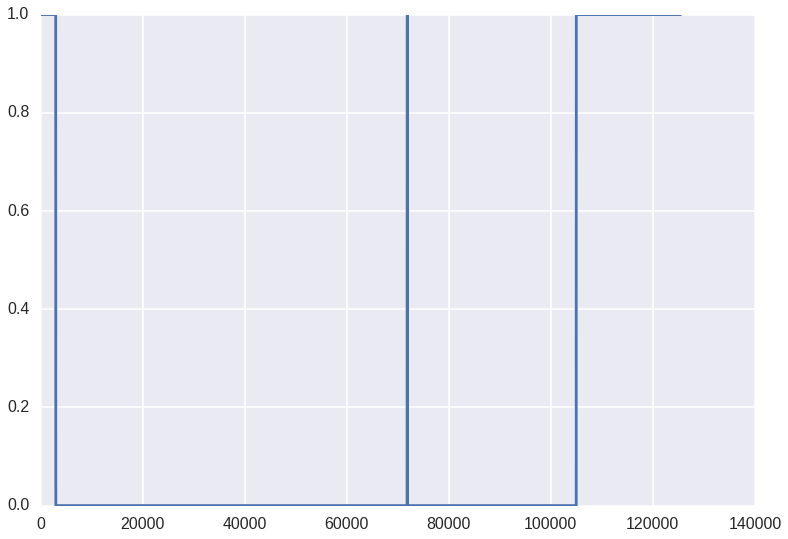

In [145]:
def normalize(df, headers):
    """Normalizes values of a dataframe after filling missing values- see FillMissing
    df: dataframe of un-normalized integer only data
    headers: specifc columns to be compared to one another
    returns: now normalized dataframe of only the specified headers with missing values filled in"""
    normdf = df[headers]
    df_norm = (normdf-normdf.mean())/(normdf.max() - normdf.min())
    return df_norm

intHeadCorrList= [ 'Temperature_(degC)','PM4_(ug/m3)', 'PM10_(ug/m3)','PM2.5_(ug/m3)','SO2_(ppb)','CO_(ppm)','NO_(ppb)',
                 'NO2_(ppb)','AvgHouse']
plt.plot(df2013[intHeadCorrList[0:1]].isnull().mean(axis=1))
dfnorm13 = normalize(df2013, intHeadCorrList)

We chose a spearman correlation because it doesn't rely on the parameters a perason's correlation does. The pandas methof dataframe.corr let us pick spearman, ignores nans (a must have) and constructs a useful dataframe of correlation coefficients that just make the whole matrix process a lot less painful.


In [146]:
speardf = dfnorm13.corr(method = 'spearman')
print speardf.head()

                    Temperature_(degC)  PM4_(ug/m3)  PM10_(ug/m3)  \
Temperature_(degC)            1.000000     0.025234      0.320008   
PM4_(ug/m3)                   0.025234     1.000000      0.388485   
PM10_(ug/m3)                  0.320008     0.388485      1.000000   
PM2.5_(ug/m3)                 0.012230     0.349414      0.353744   
SO2_(ppb)                     0.375853     0.280002      0.455247   

                    PM2.5_(ug/m3)  SO2_(ppb)  CO_(ppm)  NO_(ppb)  NO2_(ppb)  \
Temperature_(degC)       0.012230   0.375853 -0.252044  0.083755   0.172606   
PM4_(ug/m3)              0.349414   0.280002  0.137353  0.389796   0.278899   
PM10_(ug/m3)             0.353744   0.455247  0.217672  0.268485   0.454548   
PM2.5_(ug/m3)            1.000000   0.162776  0.310283  0.146666   0.291135   
SO2_(ppb)                0.162776   1.000000  0.282189  0.517021   0.717334   

                    AvgHouse  
Temperature_(degC)  0.346387  
PM4_(ug/m3)        -0.112542  
PM10_(ug/m3)     

In [147]:
def correlationHeatmap(corrmat, year = ''):
    """Constructs a heatmap correlation matrix
    corrmat: dataframe of correlation constants
    year: year to which data applies"""
#set up mask to cover upper triangle of the matrix 
    mask = np.zeros_like(speardf, dtype=np.bool)
    mask[np.triu_indices_from(mask, k=1)] = True

# Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
    sns.heatmap(corrmat,mask=mask, vmax=.8, square=True)

    plt.title('Winter of '+ year+ ' Temperature and Pollutant Correlations')
    plt.xticks(rotation=30)
    f.tight_layout()

This code for a cross correlation heatmap taken from some helpful seaborn documentation from stanford: https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.heatmap.html

#### From these maps we can see what features are most strongly correlated

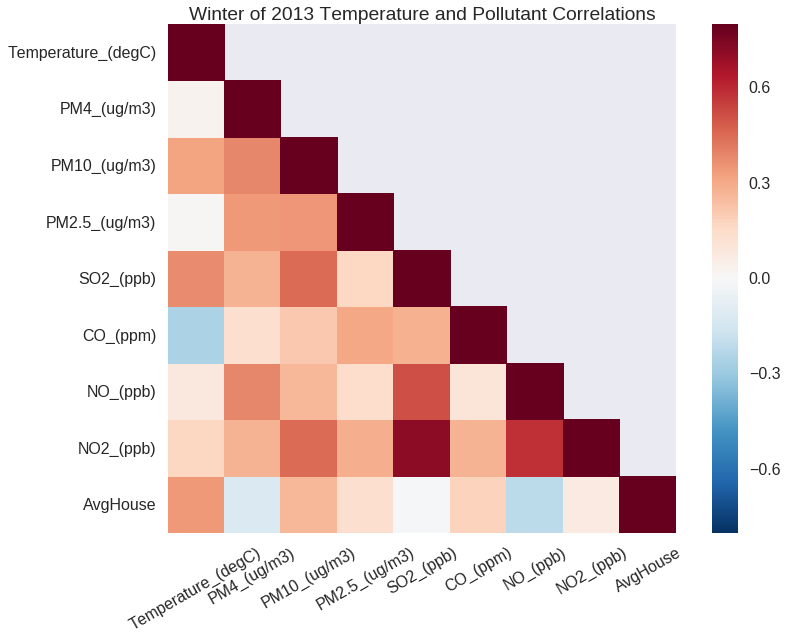

In [148]:
correlationHeatmap(speardf, '2013')


Do this with 2014, cold, warm, hot, and diurnal profiles

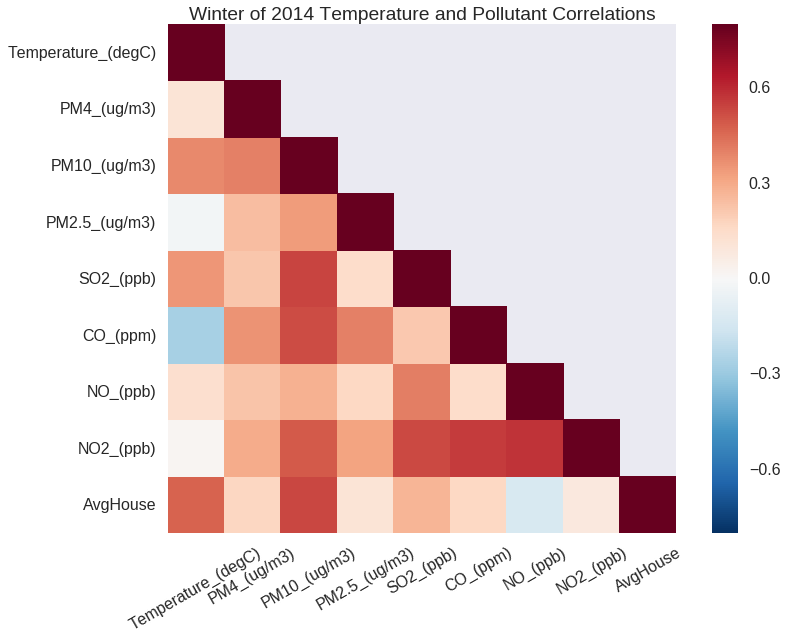

In [149]:
dfnorm14 = normalize(df2014, intHeadCorrList)
speardf14 = dfnorm14.corr(method = 'spearman')
correlationHeatmap(speardf14, '2014')

Difference between temperature brackets

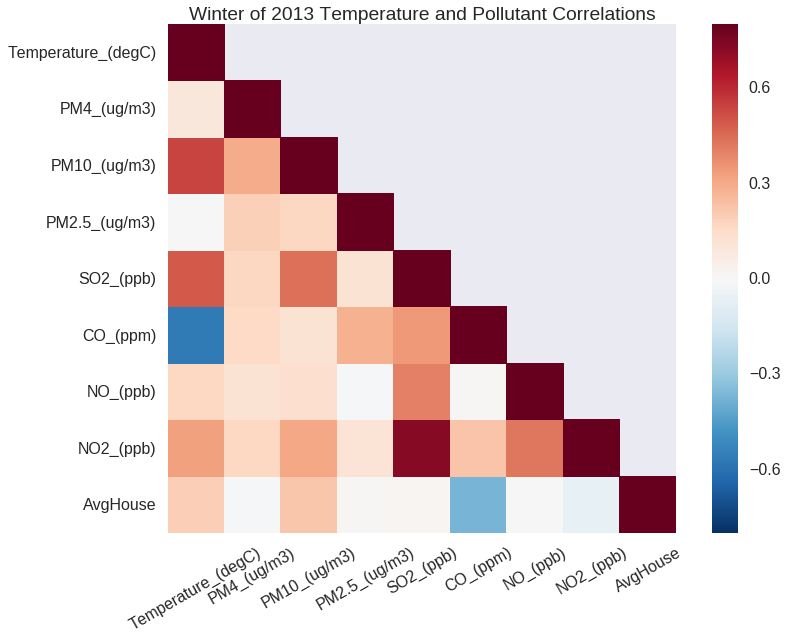

In [150]:
dfnormwarm13 = normalize(df2013warm, intHeadCorrList)
speardfwarm13 = dfnormwarm13.corr(method = 'spearman')
correlationHeatmap(speardfwarm13, '2013')

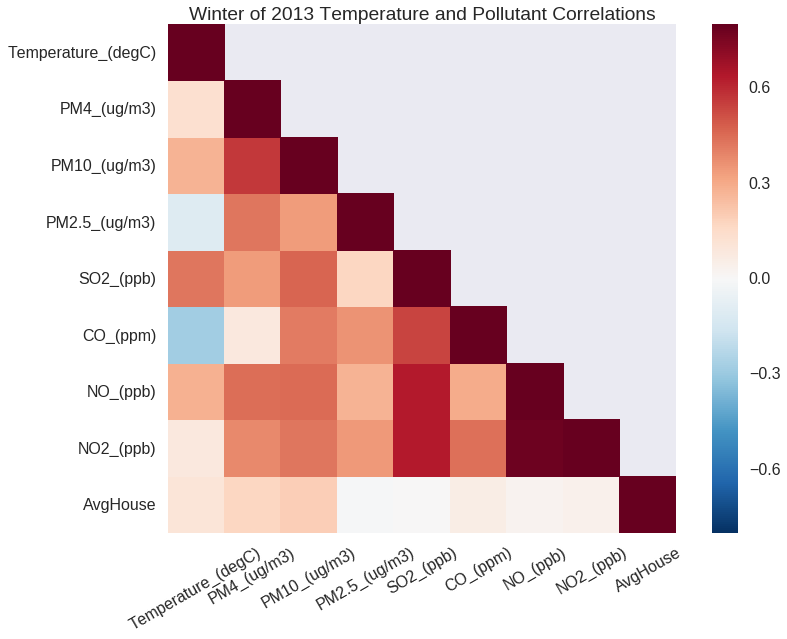

In [151]:
dfnormcold13 = normalize(df2013cold, intHeadCorrList)
speardfcold13 = dfnormcold13.corr(method = 'spearman')
correlationHeatmap(speardfcold13, '2013')

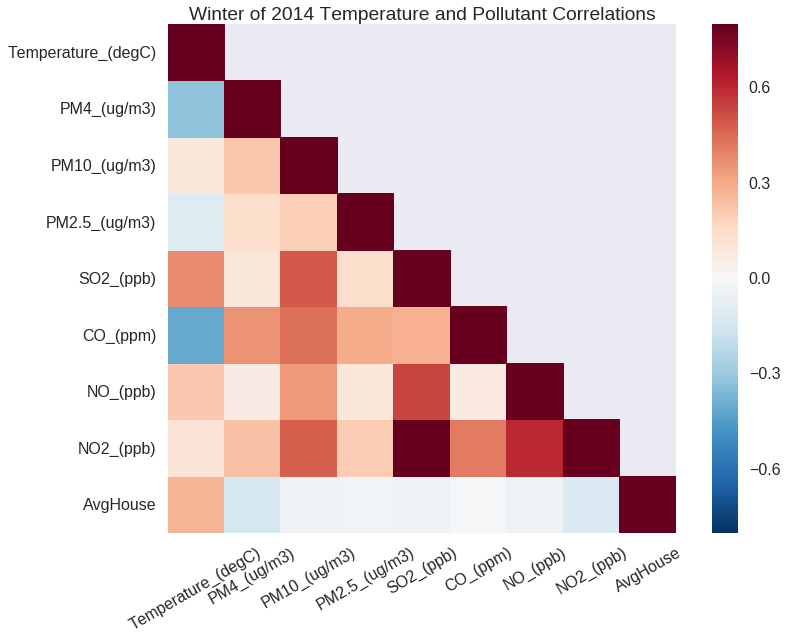

In [152]:

dfnormwarm14 = normalize(df2014warm, intHeadCorrList)
speardfwarm14 = dfnormwarm14.corr(method = 'spearman')
correlationHeatmap(speardfwarm14, '2014')

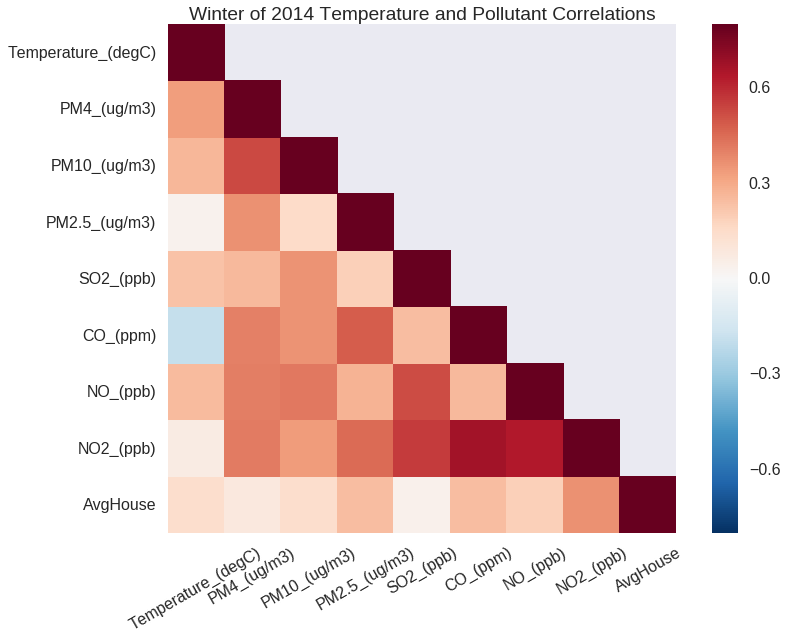

In [153]:
dfnormcold14 = normalize(df2014cold, intHeadCorrList)
speardfcold14 = dfnormcold14.corr(method = 'spearman')
correlationHeatmap(speardfcold14, '2014')